In [137]:
from ultralytics import SAM

# Load a model
model = SAM("../sam_b.pt")

# Display model information (optional)
model.info()


Model summary: 173 layers, 93,735,472 parameters, 93,735,472 gradients


(173, 93735472, 93735472, 0.0)

In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import ffmpeg
import shutil
import json
from scipy.ndimage import convolve
import csv


def extract_frames(video_path, output_folder, interval):
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg.input(video_path, ss=0).output(
        f"{output_folder}frame_%03d.png", vf=f"fps=1/{interval}"
    ).run()


def create_SAM_mask(image_path, point,  enhance=False, ):
    frame = cv2.imread(image_path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if enhance:
        gaussian = cv2.GaussianBlur(gray, (0, 0), sigmaX=3)
        enhanced = cv2.addWeighted(gray, 1.5, gaussian, -0.5, 0)
    else:
        enhanced = gray
    enhanced_frame = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

    temp_path = image_path.replace(".png", "_enhanced.png")
    cv2.imwrite(temp_path, enhanced_frame)

    # Segment using the enhanced image
    results = model(temp_path, points=point, labels=[1])

    # Create a binary mask from the result
    b_mask = np.zeros(frame.shape[:2], np.uint8)
    contour = results[0].masks.xy.pop()
    contour = contour.astype(np.int32)
    contour = contour.reshape(-1, 1, 2)
    _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

    # Optionally: remove the temp file
    os.remove(temp_path)

    return enhanced_frame, b_mask

def track_width(
    frame_folder,
    start_frame,
    anchor_point,
    output_file,
    end_frame=None,
    opening_kernel=(3, 3),
    debug=False,
    reverse_order=False,
    enhance_original_image=False
):
    import torch
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir != '' and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    frames = sorted(
        [
            os.path.join(frame_folder, f)
            for f in os.listdir(frame_folder)
            if f.endswith((".png", ".jpg"))
        ]
    )

    start_frame = max(0, start_frame)
    end_frame = min(len(frames), end_frame if end_frame is not None else len(frames))
    print(f"Analyzing frames {start_frame} to {end_frame-1}")
    print(f"Total frames used: {end_frame - start_frame}")

    frames = frames[start_frame:end_frame]

    plt.figure(figsize=(12, 10))
    results = []
    if reverse_order:
        print('we are reversing the order')
        frames.reverse()
    for i, frame_path in enumerate(frames):
        if reverse_order:
            frame_idx = len(frames) - (i - 1)
        else:
            frame_idx = i
        frame = cv2.imread(frame_path)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        enhanced_frame, b_mask = create_SAM_mask(frame_path, anchor_point, enhance=enhance_original_image)
        kernel = np.ones(opening_kernel, np.uint8)
        cleaned_b_mask = cv2.morphologyEx(b_mask, cv2.MORPH_OPEN, kernel, iterations=5)


        if debug or frame_idx % 5 == 0:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))

            axes[0, 0].imshow(frame_rgb)
            axes[0, 0].set_title("Frame")
            axes[0, 0].axis("off")
            axes[0, 1].imshow(frame_rgb)
            axes[0, 1].set_title("Frame with Point Selected")
            size = 10  # Size of the "X"
            thickness = 2  # Thickness of the lines
            axes[0, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [anchor_point[1] - size, anchor_point[1] + size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [anchor_point[1] + size, anchor_point[1] - size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].axis("off")
            
            axes[0, 2].imshow(enhanced_frame, cmap="gray")
            axes[0, 2].set_title("Enhanced Image")
            axes[0, 2].axis("off")
            axes[1, 0].imshow(b_mask, cmap="gray")
            axes[1, 0].set_title("Binary Mask")
            axes[1, 0].axis("off")
            axes[1, 1].imshow(cleaned_b_mask, cmap="gray")
            axes[1, 1].set_title("Cleaned Binary Mask")
            axes[1, 1].axis("off")
            axes[1, 2].imshow(cleaned_b_mask)
    
    
        # import pdb; pdb.set_trace()
        # row = cleaned_b_mask[anchor_point[1]]  # extract the row at y=150
        column = cleaned_b_mask[:, anchor_point[0]]# > 0)[0]

        # Get indices where the value is white (nonzero)
        white_y_coords = np.where(column > 0)[0]

        assert len(white_y_coords) > 0
        bottom_most_y = np.min(white_y_coords)
        top_most_y = np.max(white_y_coords)
        width = top_most_y - bottom_most_y
        print(f"Frame {frame_idx}: Width = {width} bottom_most_y = {bottom_most_y} top_most_y = {top_most_y}")
        results.append([frame_idx, width])

        if debug or frame_idx % 5 == 0:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))

            axes[0, 0].imshow(frame_rgb)
            axes[0, 0].set_title("Frame")
            axes[0, 0].axis("off")
            axes[0, 1].imshow(frame_rgb)
            axes[0, 1].set_title("Frame with Point Selected")
            size = 10  # Size of the "X"
            thickness = 2  # Thickness of the lines
            axes[0, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [anchor_point[1] - size, anchor_point[1] + size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [anchor_point[1] + size, anchor_point[1] - size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].axis("off")
            
            axes[0, 2].imshow(enhanced_frame, cmap="gray")
            axes[0, 2].set_title("Enhanced Image")
            axes[0, 2].axis("off")
            axes[1, 0].imshow(b_mask, cmap="gray")
            axes[1, 0].set_title("Binary Mask")
            axes[1, 0].axis("off")
            axes[1, 1].imshow(cleaned_b_mask, cmap="gray")
            axes[1, 1].set_title("Cleaned Binary Mask")
            axes[1, 1].axis("off")
            axes[1, 2].imshow(cleaned_b_mask)
            axes[1, 2].set_title(f"Top & Bottom Points (width: {width})")
            size = 10  # Size of the "X"
            thickness = 2  # Thickness of the lines
            axes[1, 2].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [top_most_y - size, top_most_y + size],
                color="blue",
                linewidth=thickness,
            )
            axes[1, 2].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [top_most_y + size, top_most_y - size],
                color="blue",
                linewidth=thickness,
            )
            axes[1, 2].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [bottom_most_y - size, bottom_most_y + size],
                color="red",
                linewidth=thickness,
            )
            axes[1, 2].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [bottom_most_y + size, bottom_most_y - size],
                color="red",
                linewidth=thickness,
            )
            axes[1, 2].axis("off")
            plt.tight_layout()
            plt.show()
    
    # 💾 Write to CSV
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['frame_idx', 'width'])
        writer.writerows(results)

    print(f"Widths saved to {output_file}")


# Start with the 20C experiment tracking the WT 

In [139]:
# # Set paths
# output_name = 'WT_strain_rate_20C.csv'
# video_name = f"drying_take_1_100x" # without the .mov
# video_path = f"{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 3
# end_frame = None
# frame_interval=0.6
# point = (150, 360)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_width(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=output_name,
#     anchor_point=point,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [140]:
# # Set paths
# output_name = 'BslA_strain_rate_20C.csv'
# video_name = f"drying_take_1_100x" # without the .mov
# video_path = f"{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 3
# end_frame = None
# frame_interval=0.6
# point = (520, 360)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_width(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=output_name,
#     anchor_point=point,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

# Now calculate the drying rate for 120C

In [141]:
# # Set paths
# output_name = 'BslA_strain_rate_120C.csv'
# video_name = f"drying_take_2_100x" # without the .mov
# video_path = f"{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 0
# end_frame = None
# frame_interval=0.6
# point = (150, 360)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_width(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=output_name,
#     anchor_point=point,
#     reverse_order=False,
#     enhance_original_image=True,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Analyzing frames 0 to 35
Total frames used: 36

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_001_enhanced.png: 1024x1024 1 0, 341.0ms
Speed: 3.2ms preprocess, 341.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 0: Width = 65 bottom_most_y = 311 top_most_y = 376


<Figure size 1200x1000 with 0 Axes>

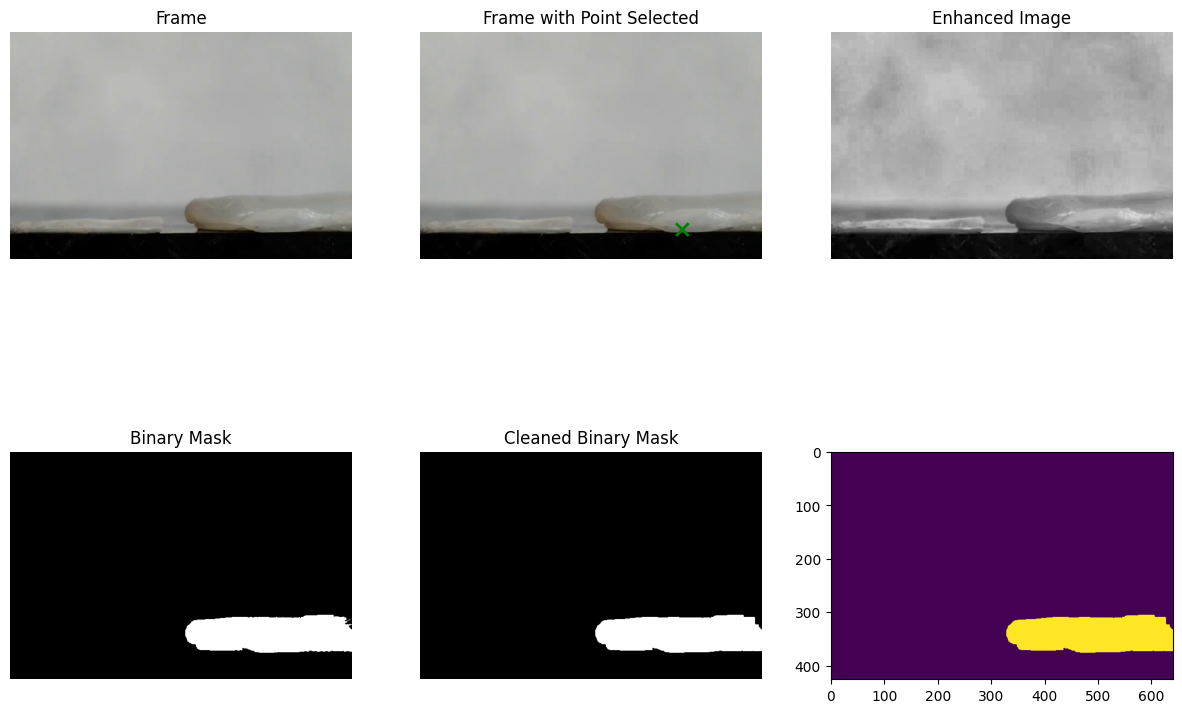

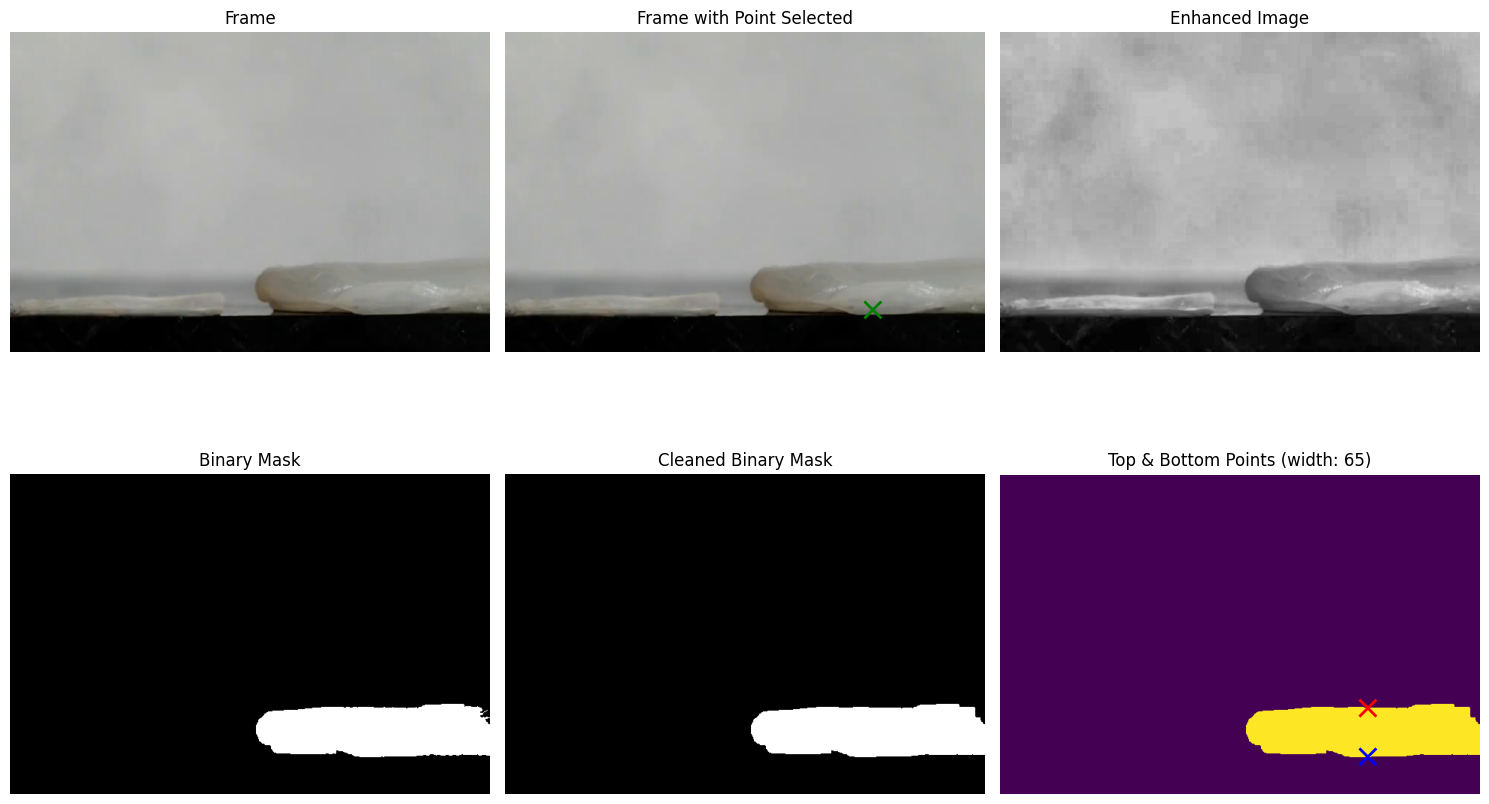


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_002_enhanced.png: 1024x1024 1 0, 324.0ms
Speed: 3.1ms preprocess, 324.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 1: Width = 66 bottom_most_y = 311 top_most_y = 377


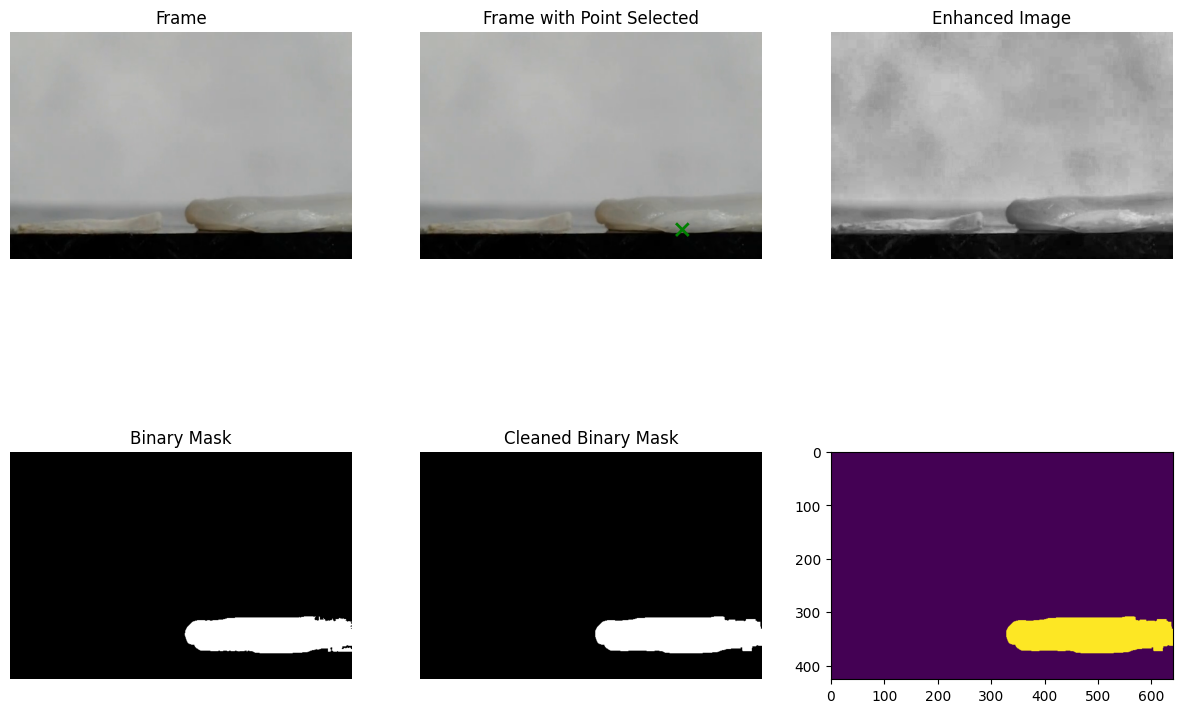

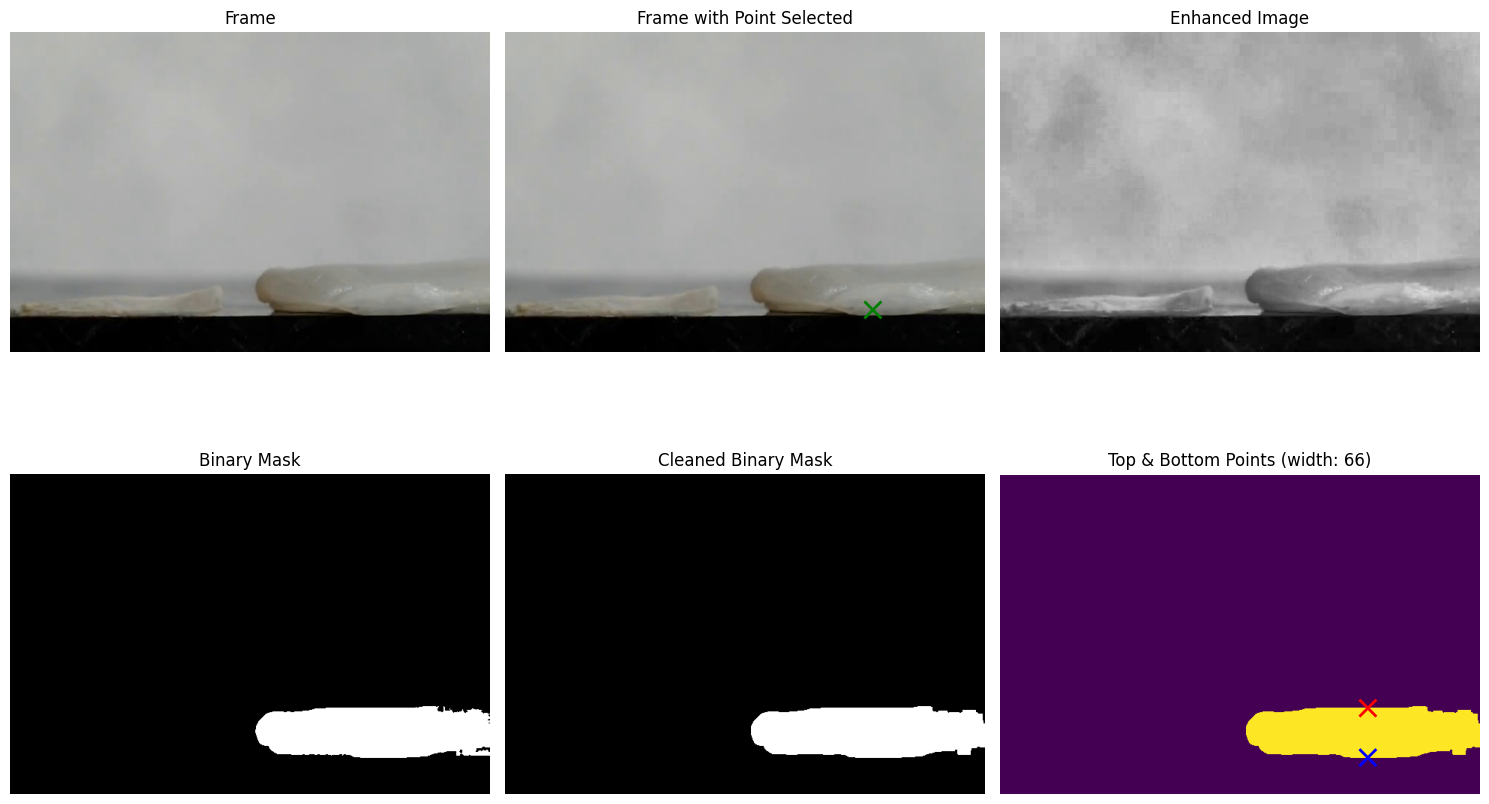


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_003_enhanced.png: 1024x1024 1 0, 318.5ms
Speed: 3.3ms preprocess, 318.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 2: Width = 60 bottom_most_y = 315 top_most_y = 375


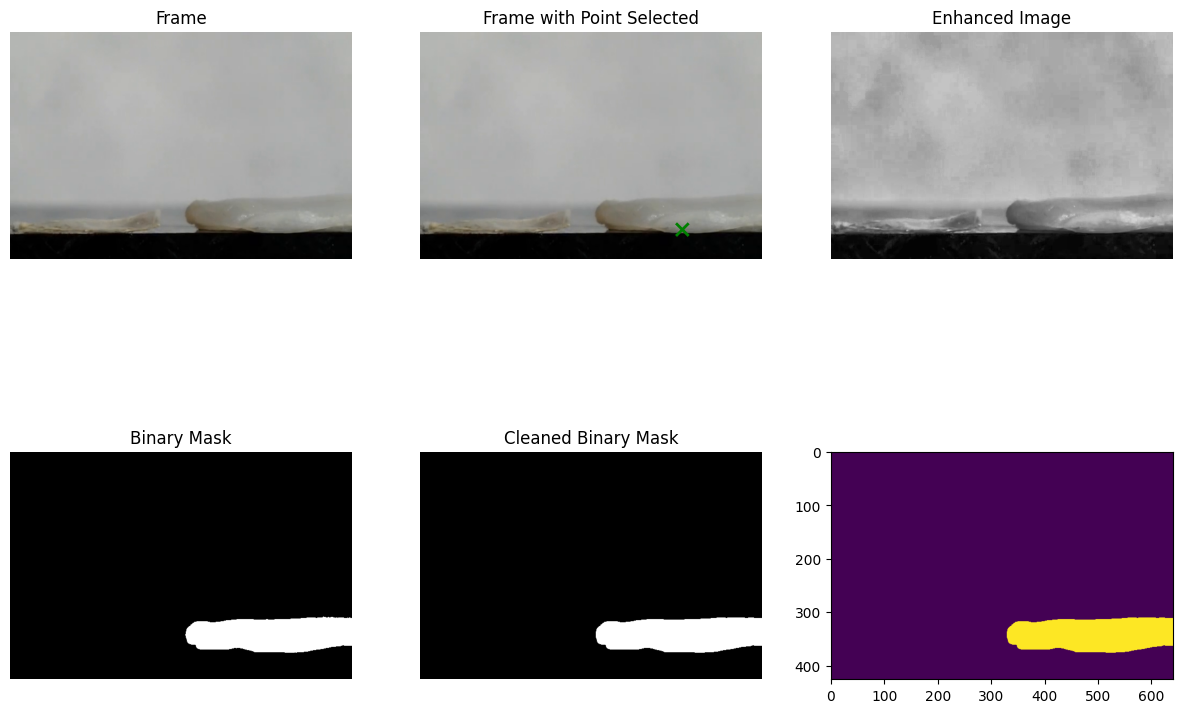

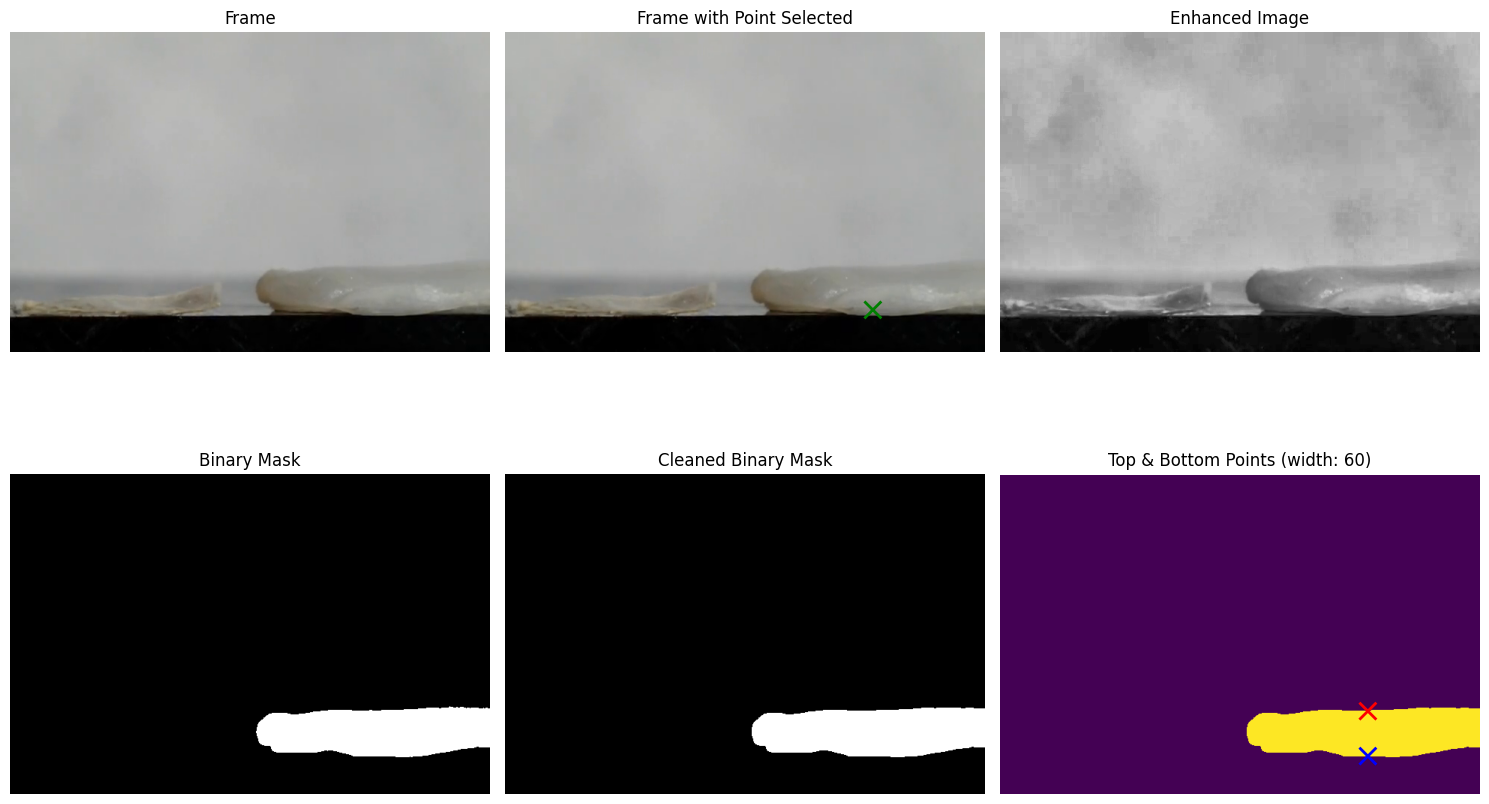


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_004_enhanced.png: 1024x1024 1 0, 338.6ms
Speed: 3.2ms preprocess, 338.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 3: Width = 60 bottom_most_y = 316 top_most_y = 376


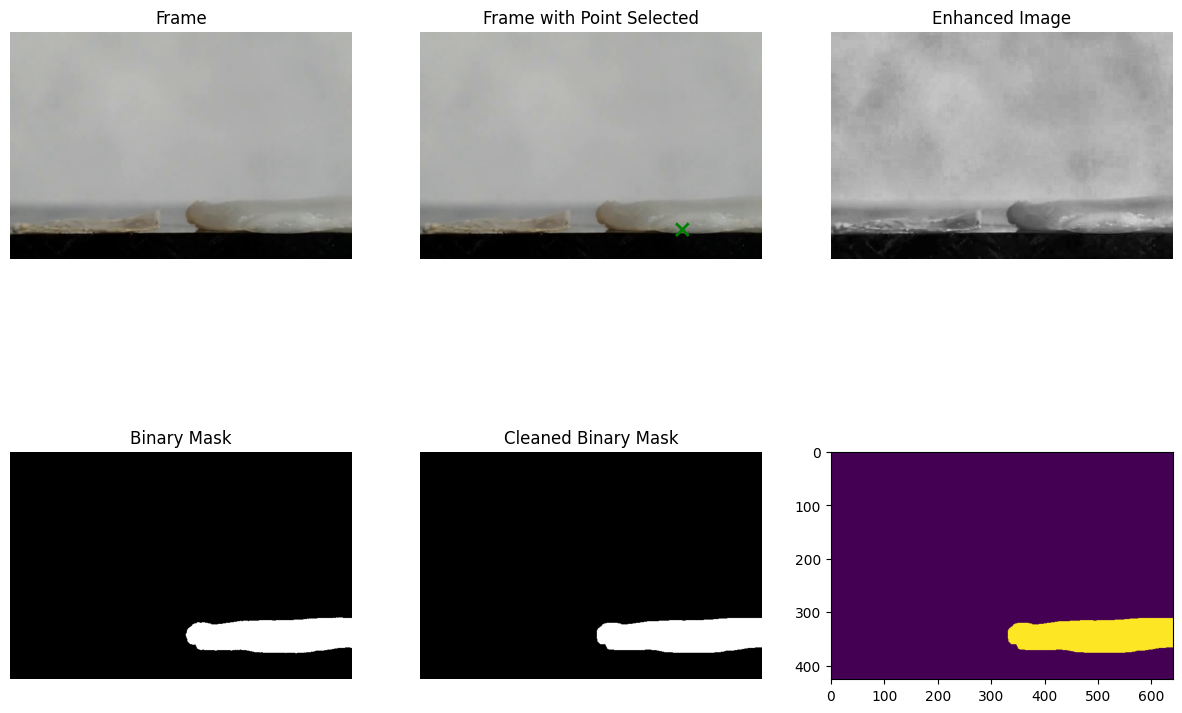

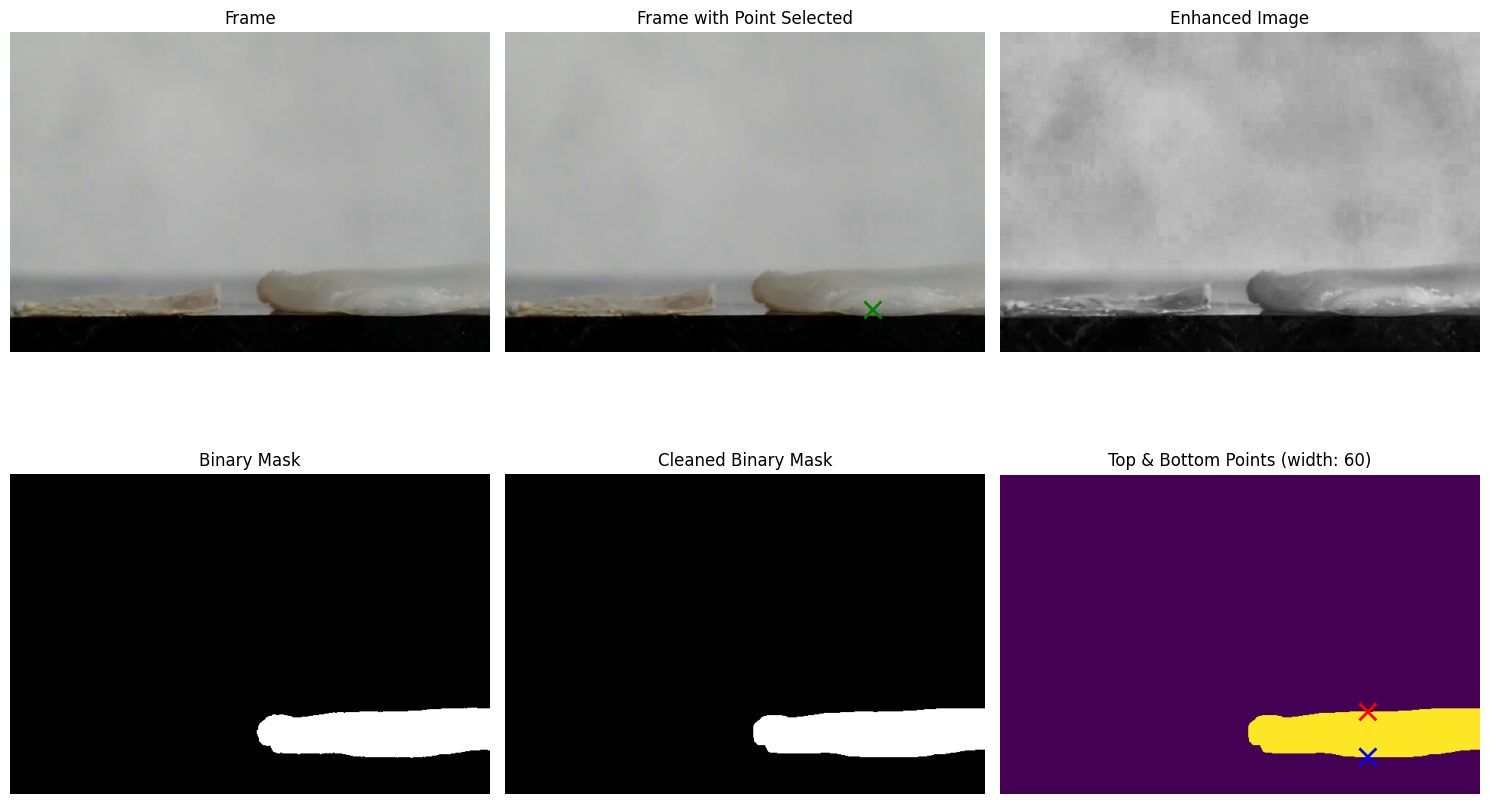


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_005_enhanced.png: 1024x1024 1 0, 338.9ms
Speed: 3.2ms preprocess, 338.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 4: Width = 54 bottom_most_y = 321 top_most_y = 375


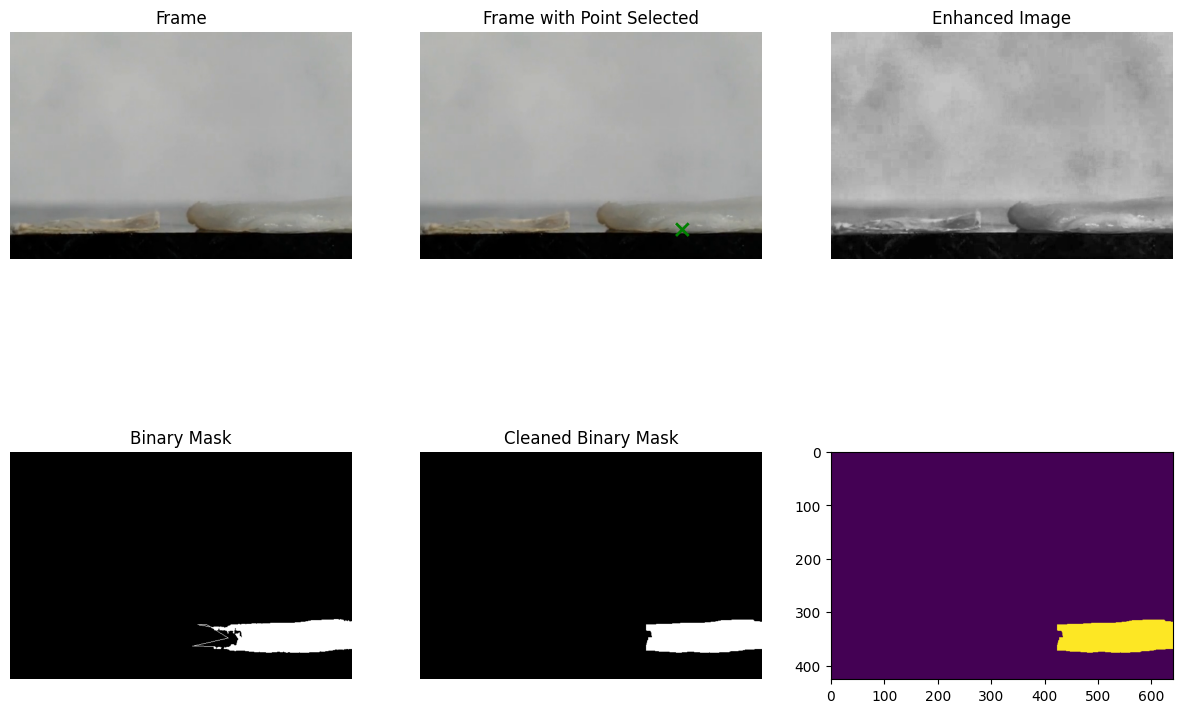

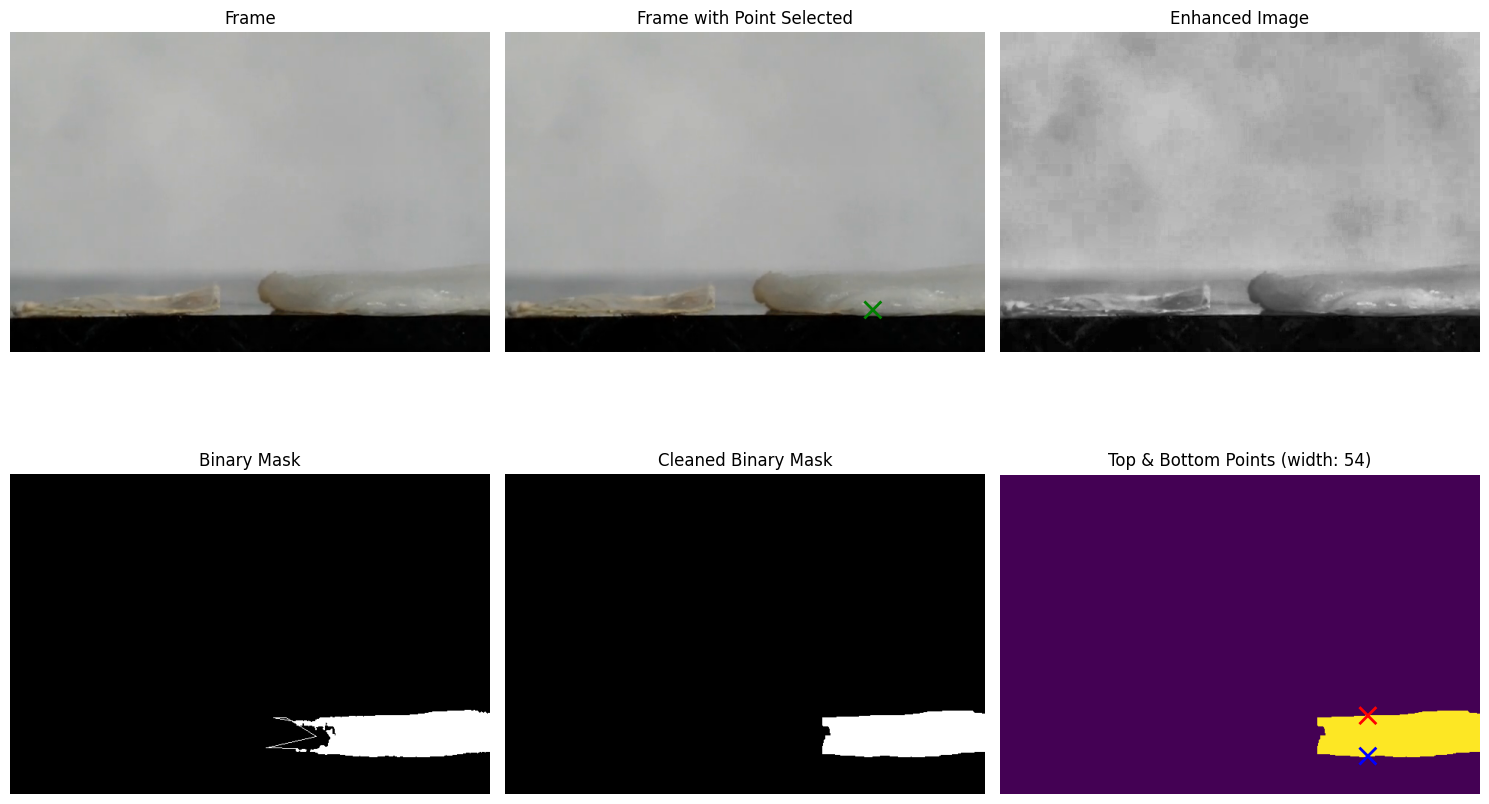


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_006_enhanced.png: 1024x1024 1 0, 331.3ms
Speed: 3.3ms preprocess, 331.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 5: Width = 53 bottom_most_y = 321 top_most_y = 374


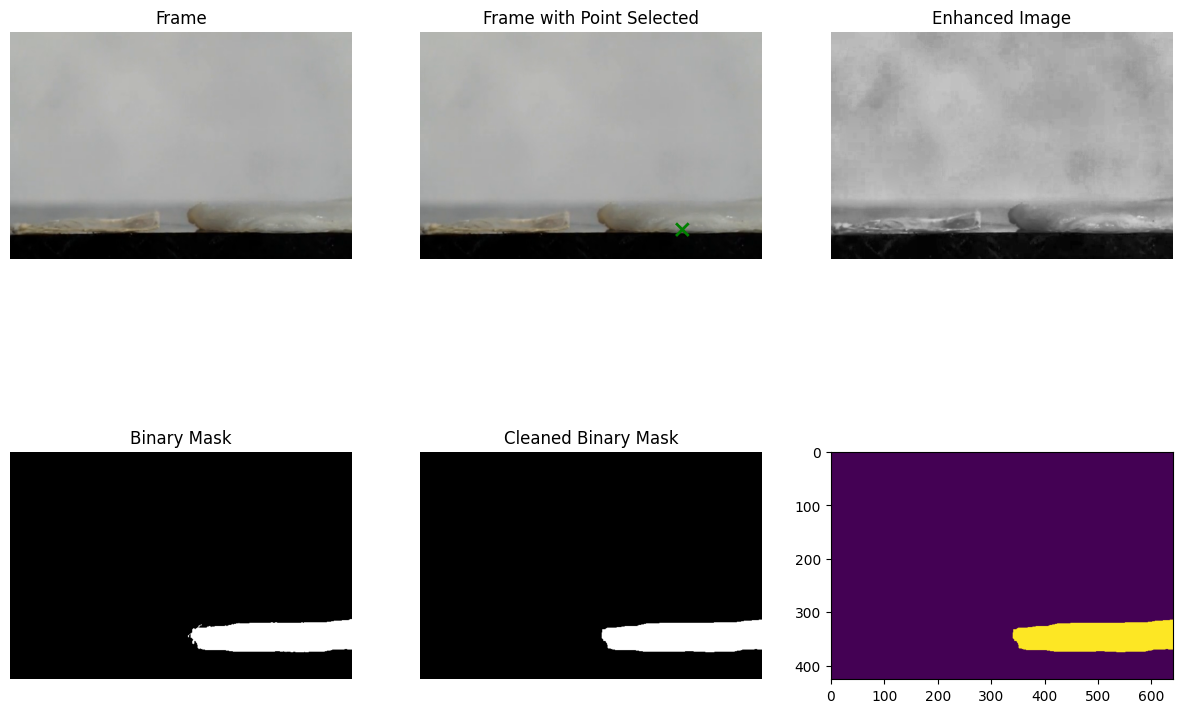

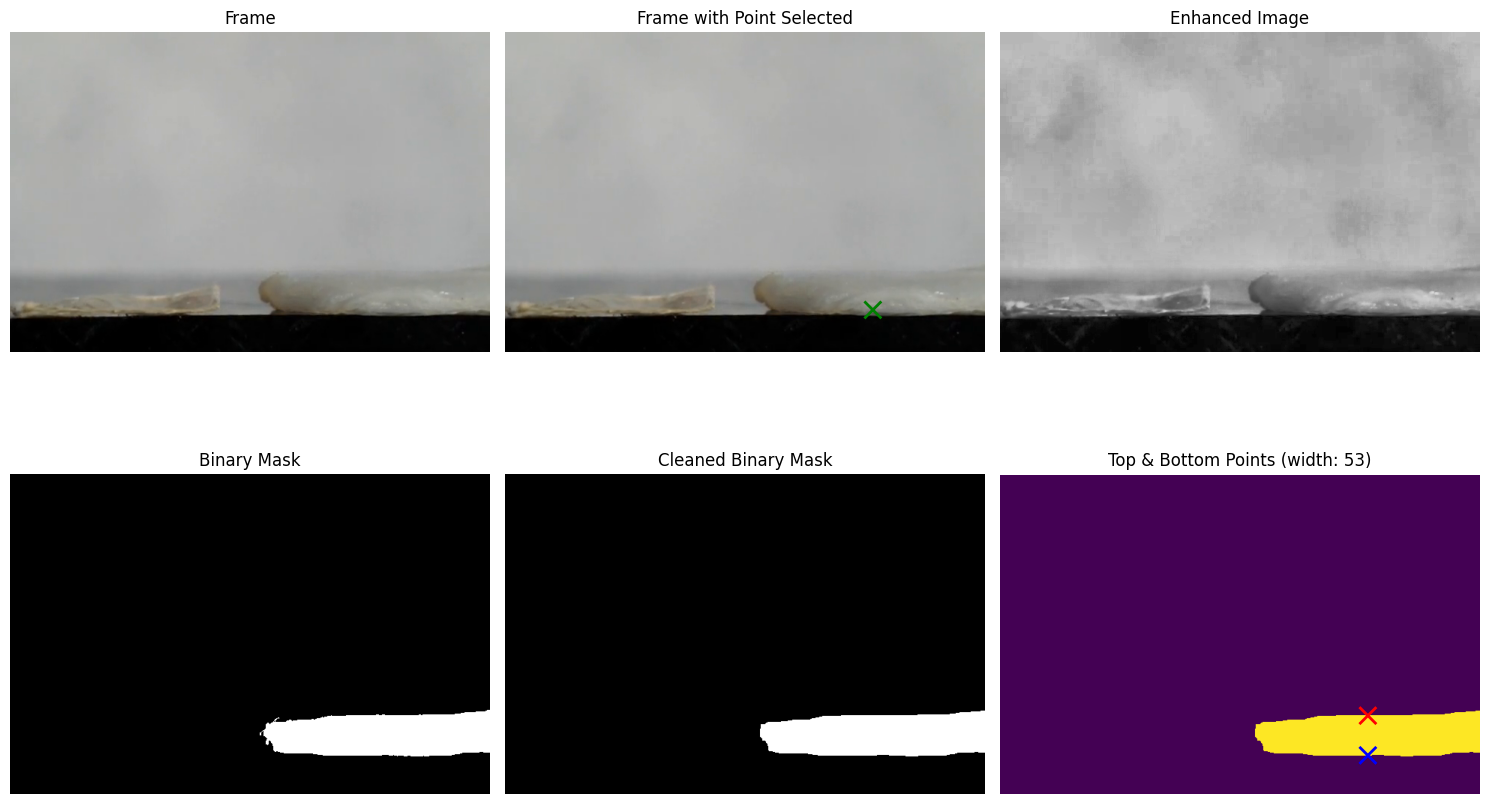


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_007_enhanced.png: 1024x1024 1 0, 332.0ms
Speed: 3.7ms preprocess, 332.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 6: Width = 51 bottom_most_y = 322 top_most_y = 373


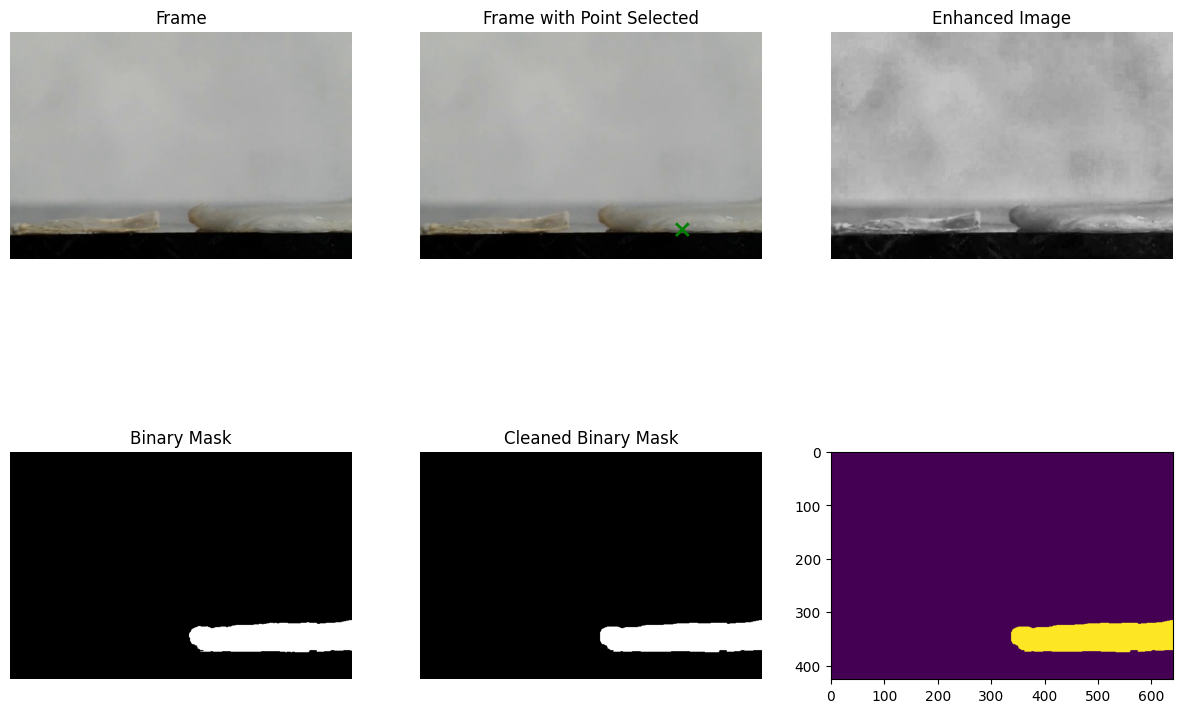

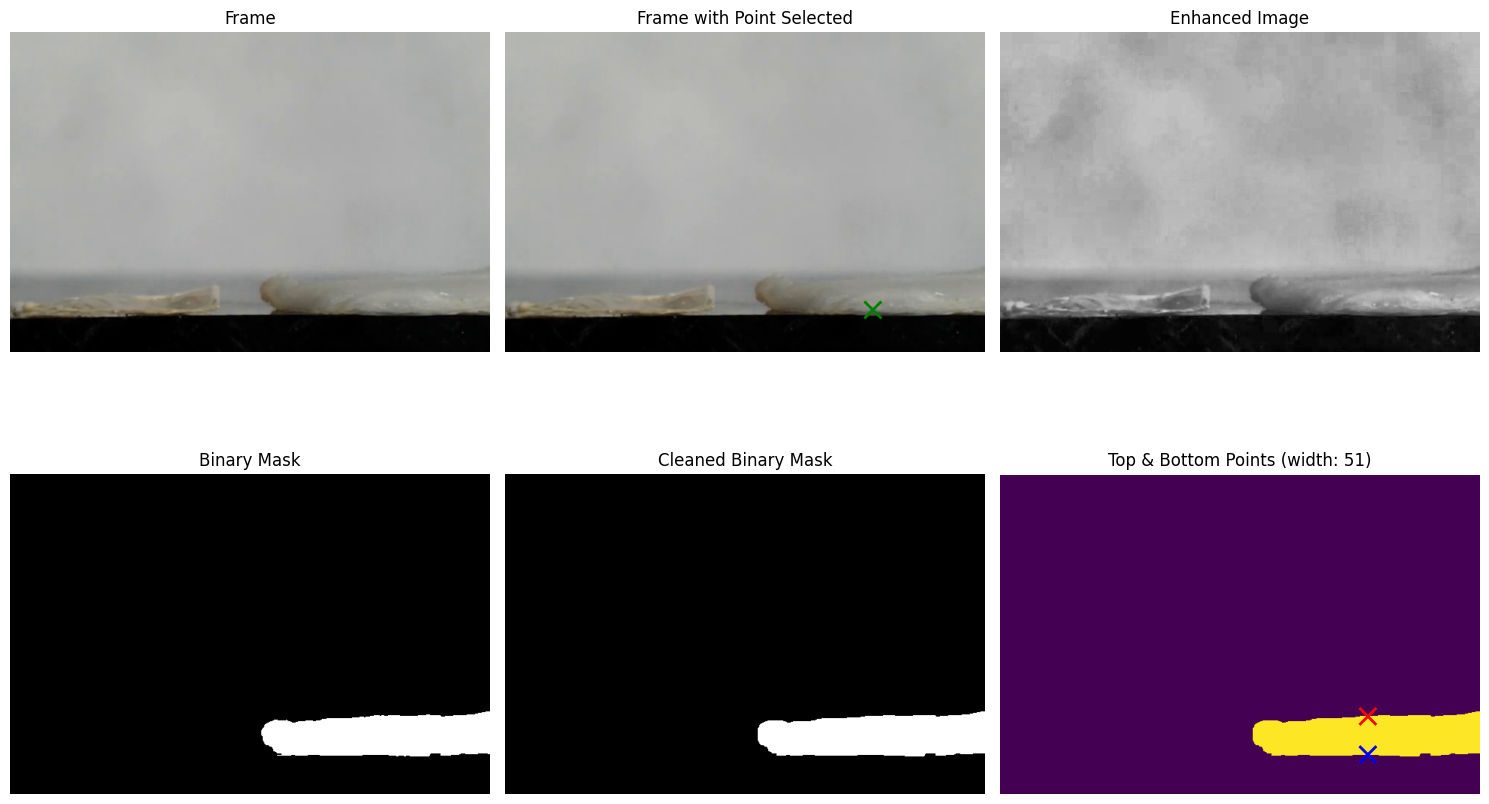


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_008_enhanced.png: 1024x1024 1 0, 336.7ms
Speed: 3.1ms preprocess, 336.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 7: Width = 49 bottom_most_y = 324 top_most_y = 373


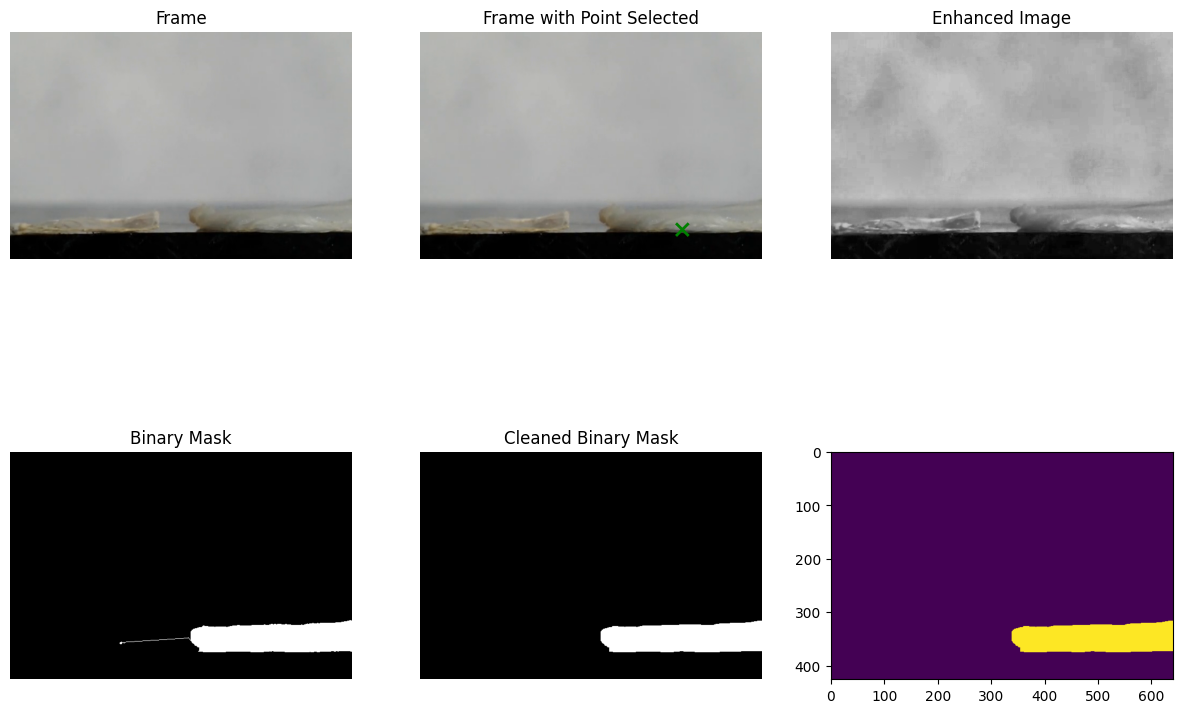

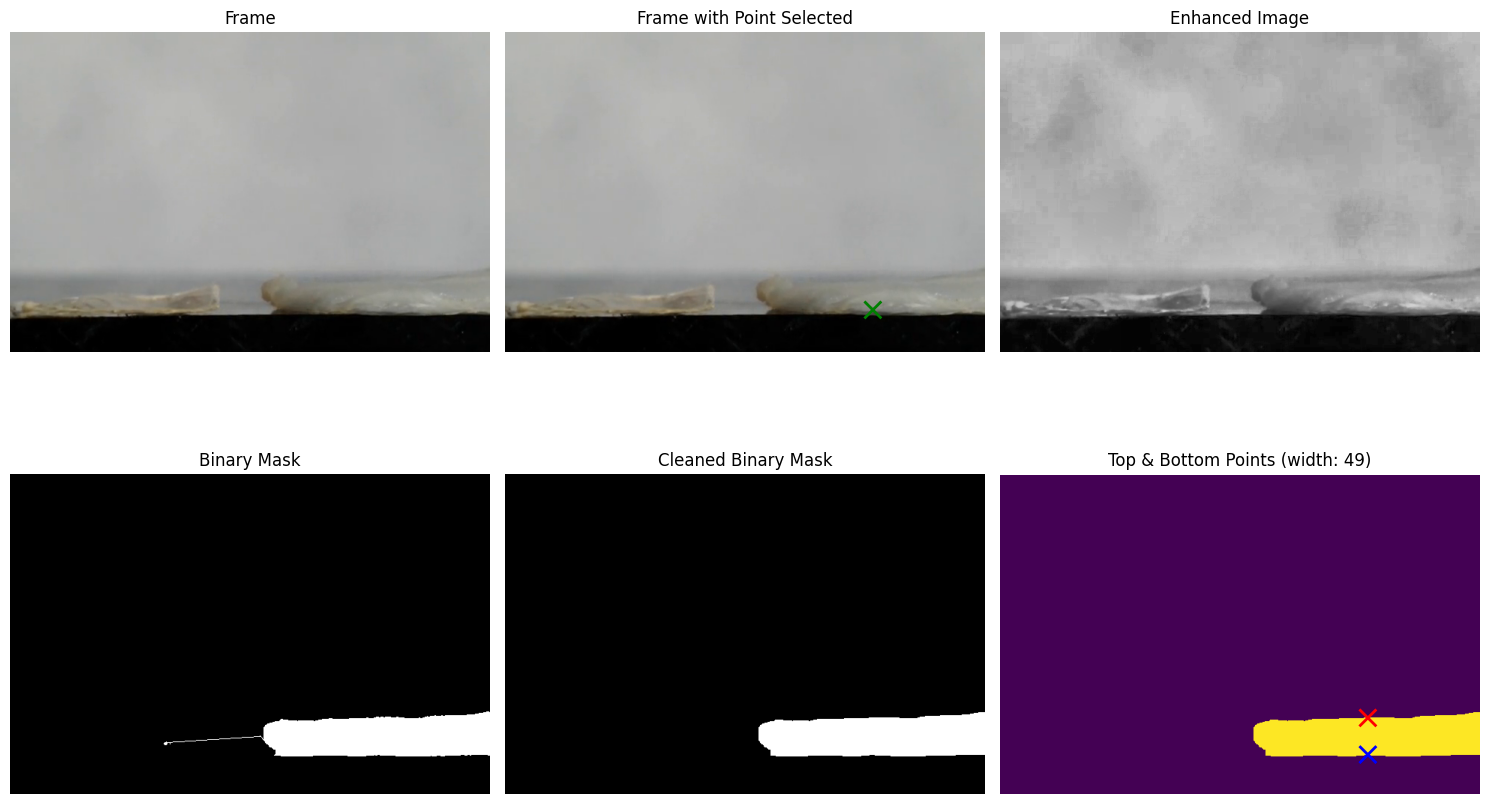


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_009_enhanced.png: 1024x1024 1 0, 330.5ms
Speed: 3.0ms preprocess, 330.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 8: Width = 45 bottom_most_y = 328 top_most_y = 373


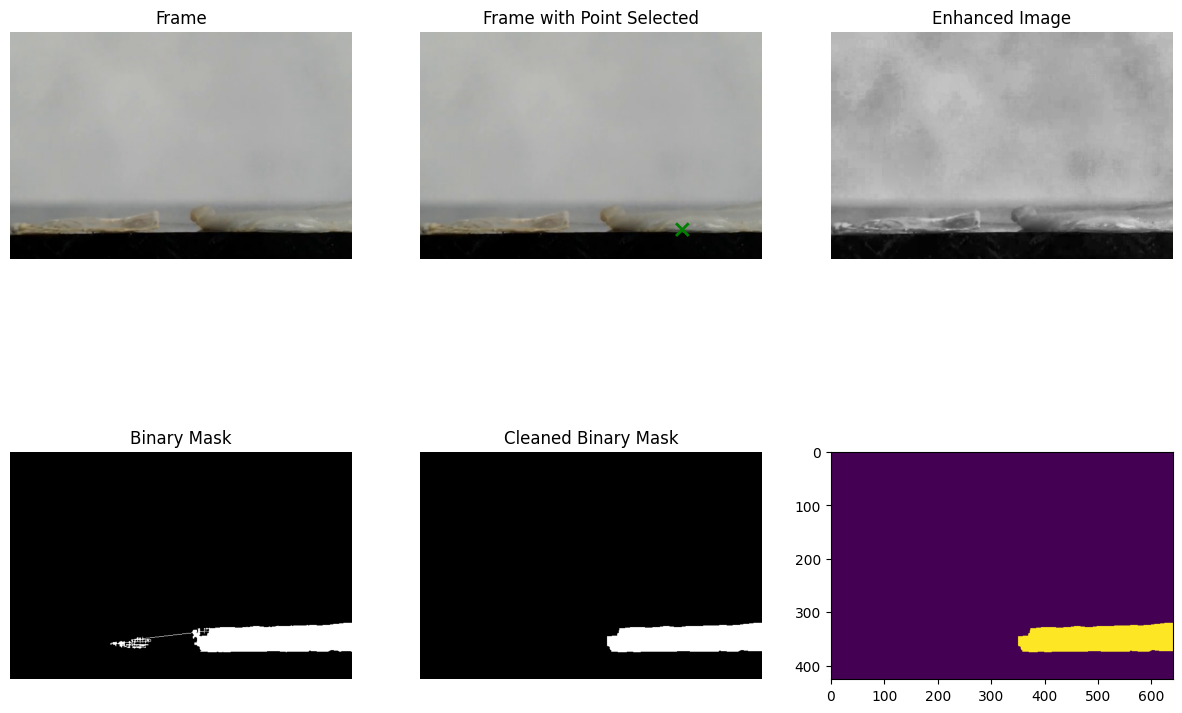

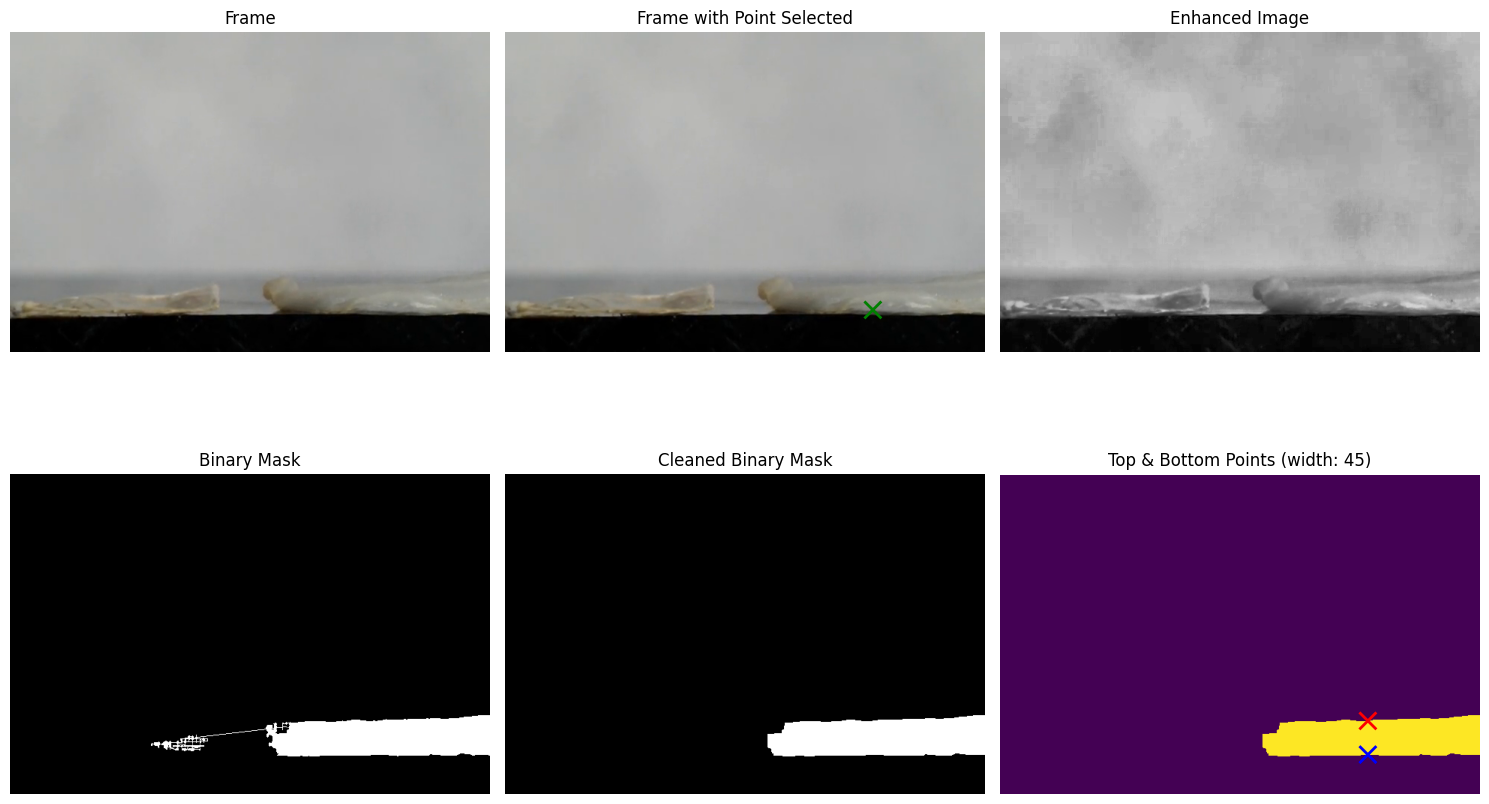


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_010_enhanced.png: 1024x1024 1 0, 342.9ms
Speed: 3.1ms preprocess, 342.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 9: Width = 49 bottom_most_y = 325 top_most_y = 374


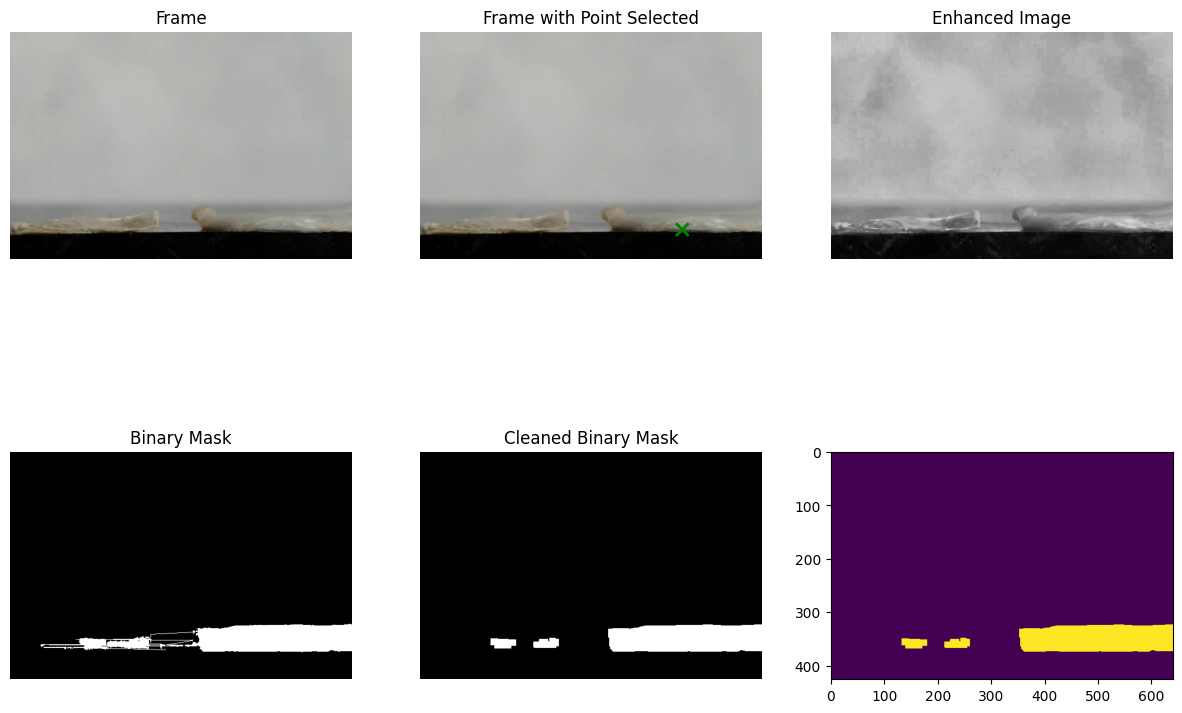

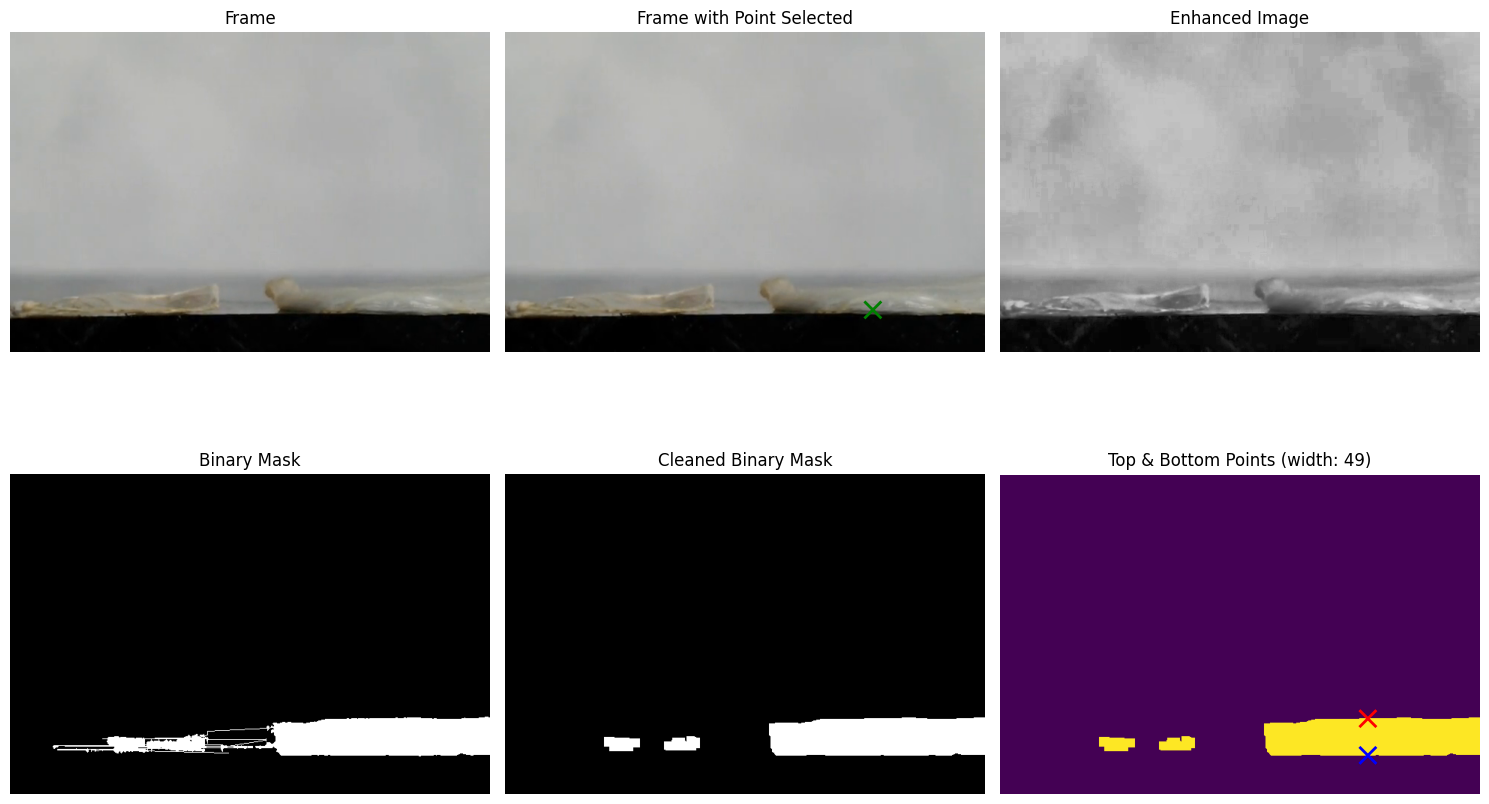


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_011_enhanced.png: 1024x1024 1 0, 325.7ms
Speed: 3.1ms preprocess, 325.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 10: Width = 47 bottom_most_y = 326 top_most_y = 373


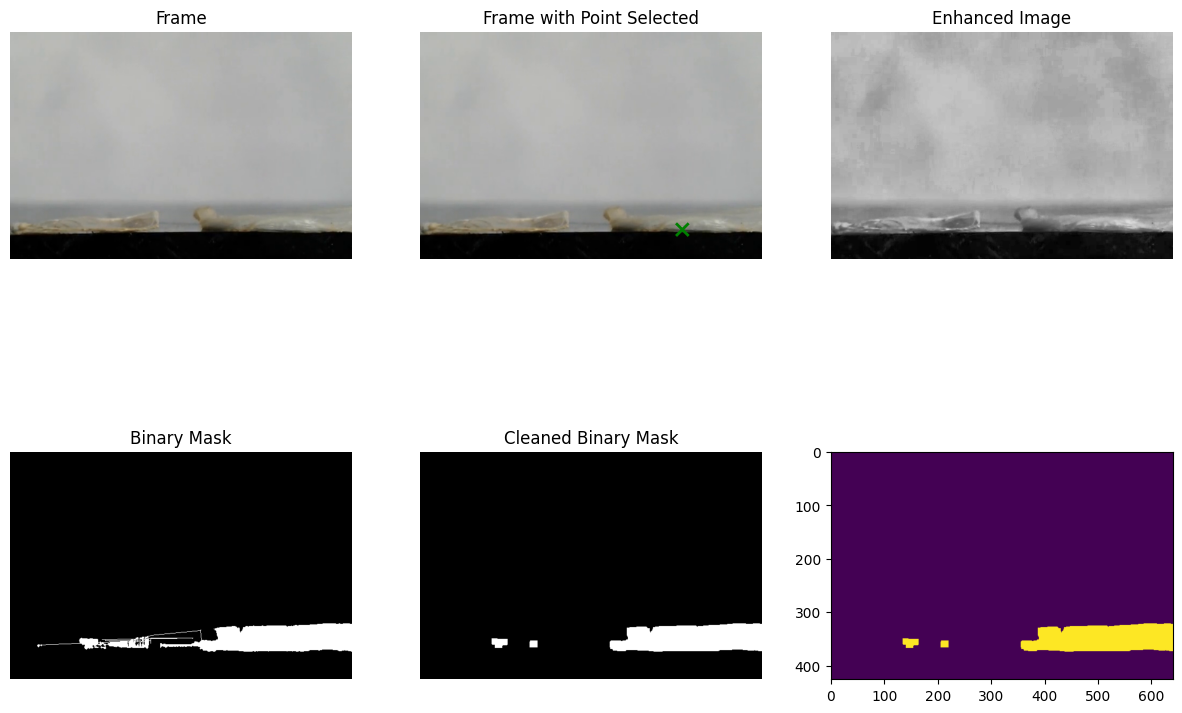

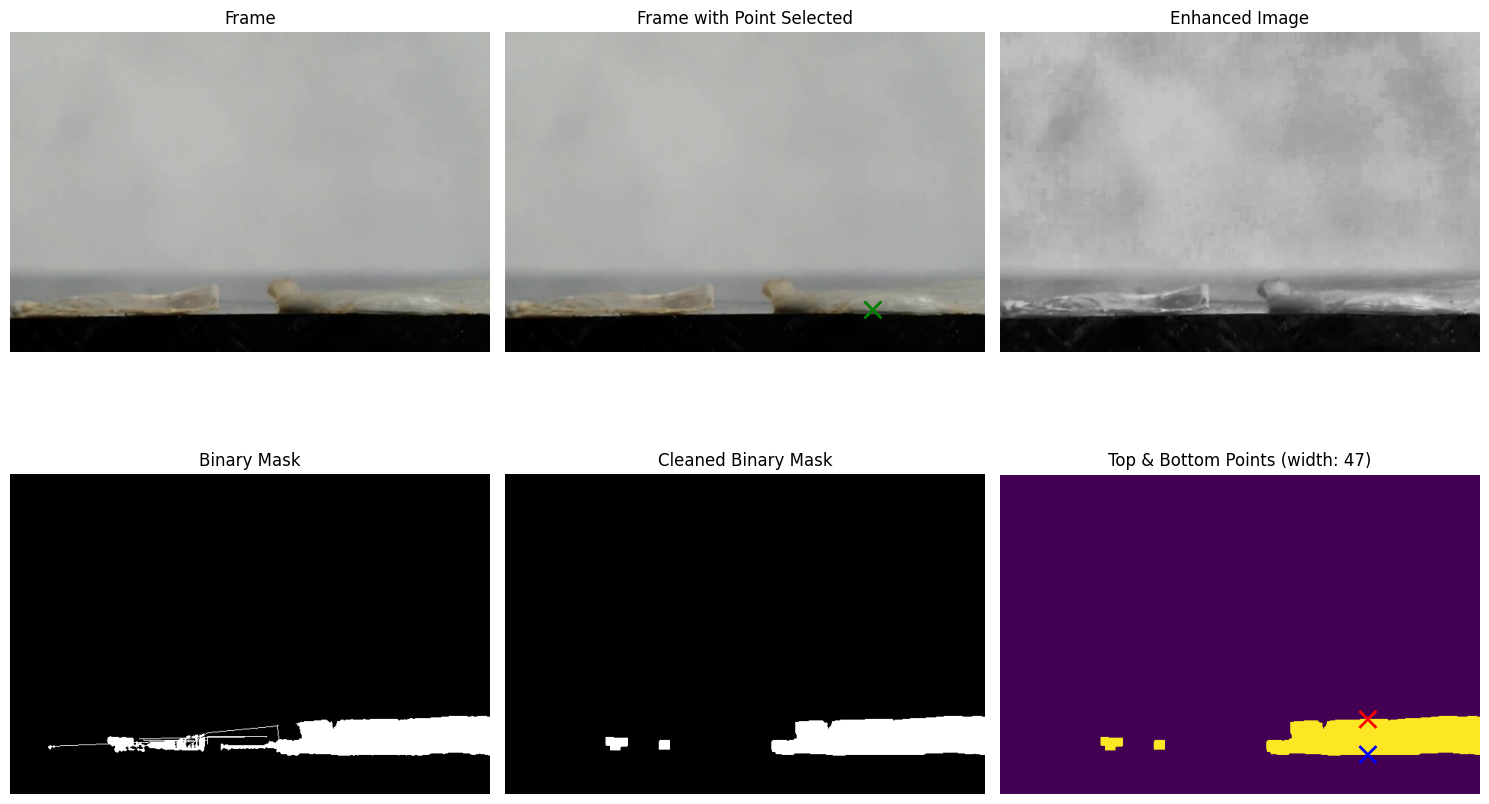


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_012_enhanced.png: 1024x1024 1 0, 324.8ms
Speed: 3.1ms preprocess, 324.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 11: Width = 46 bottom_most_y = 327 top_most_y = 373


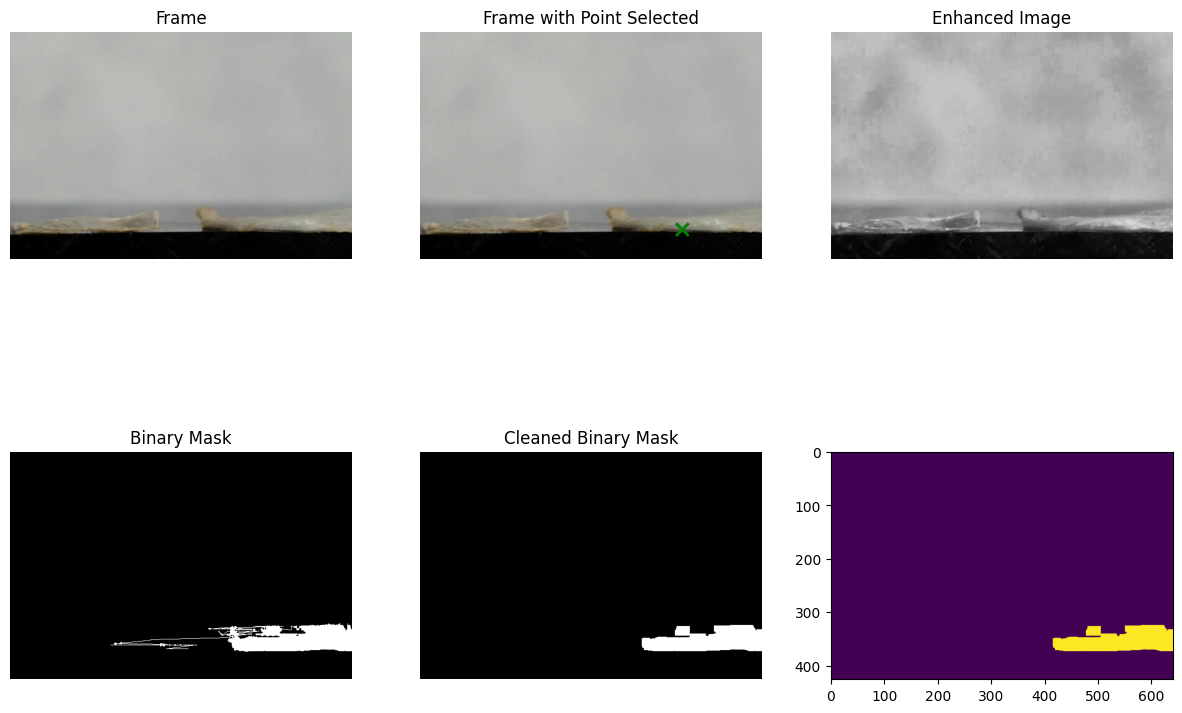

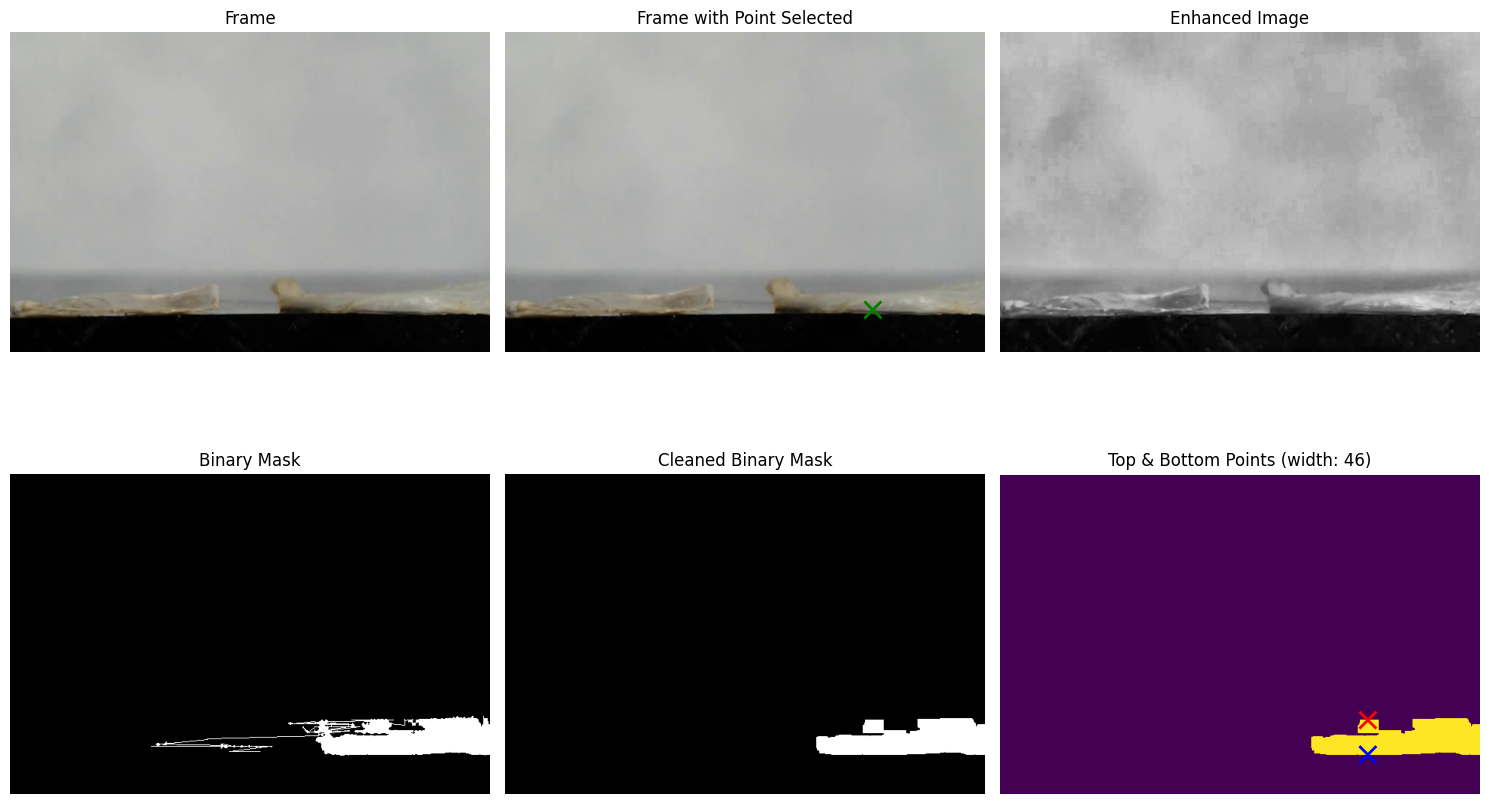


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_013_enhanced.png: 1024x1024 1 0, 325.9ms
Speed: 3.0ms preprocess, 325.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 12: Width = 24 bottom_most_y = 350 top_most_y = 374


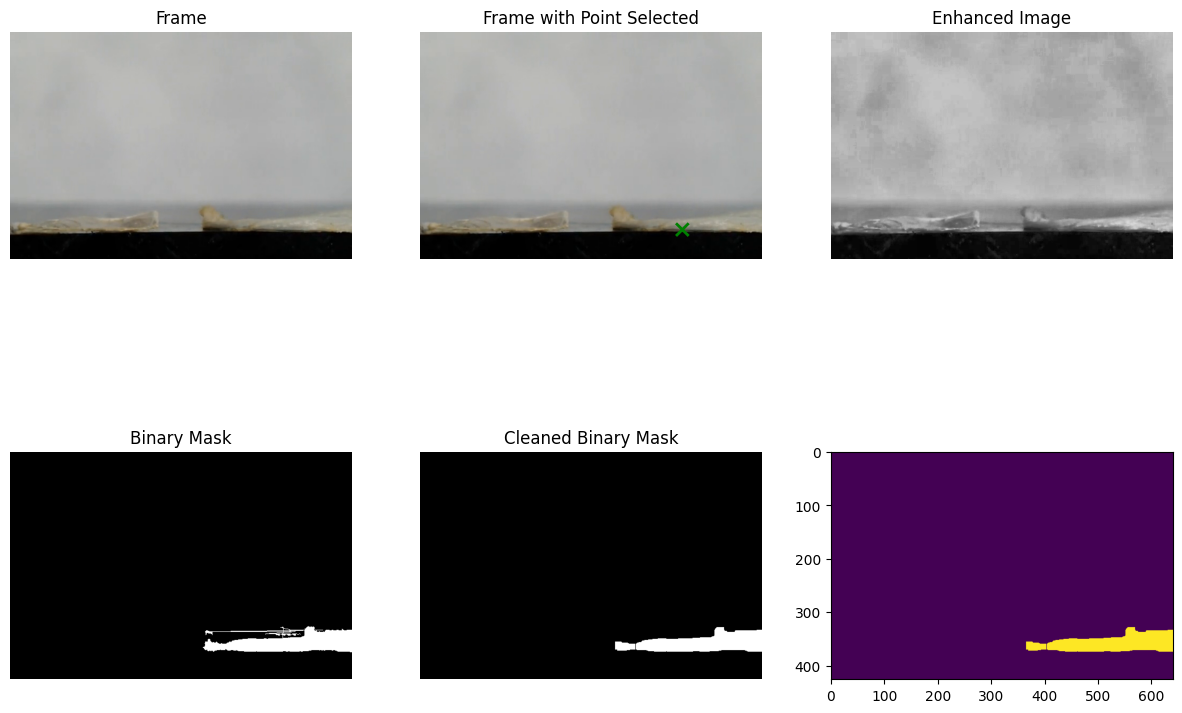

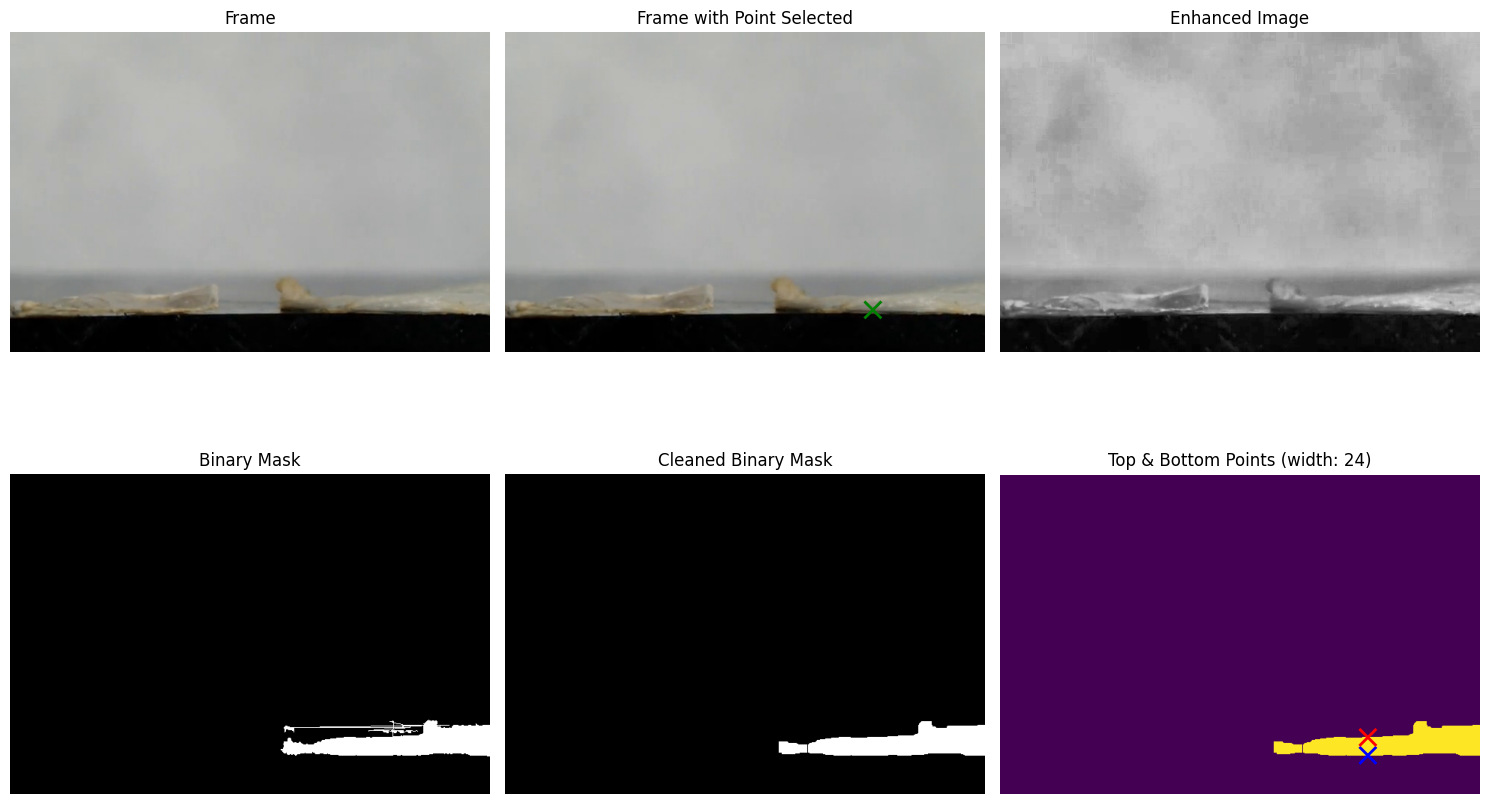


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_014_enhanced.png: 1024x1024 1 0, 325.5ms
Speed: 3.1ms preprocess, 325.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 13: Width = 18 bottom_most_y = 355 top_most_y = 373


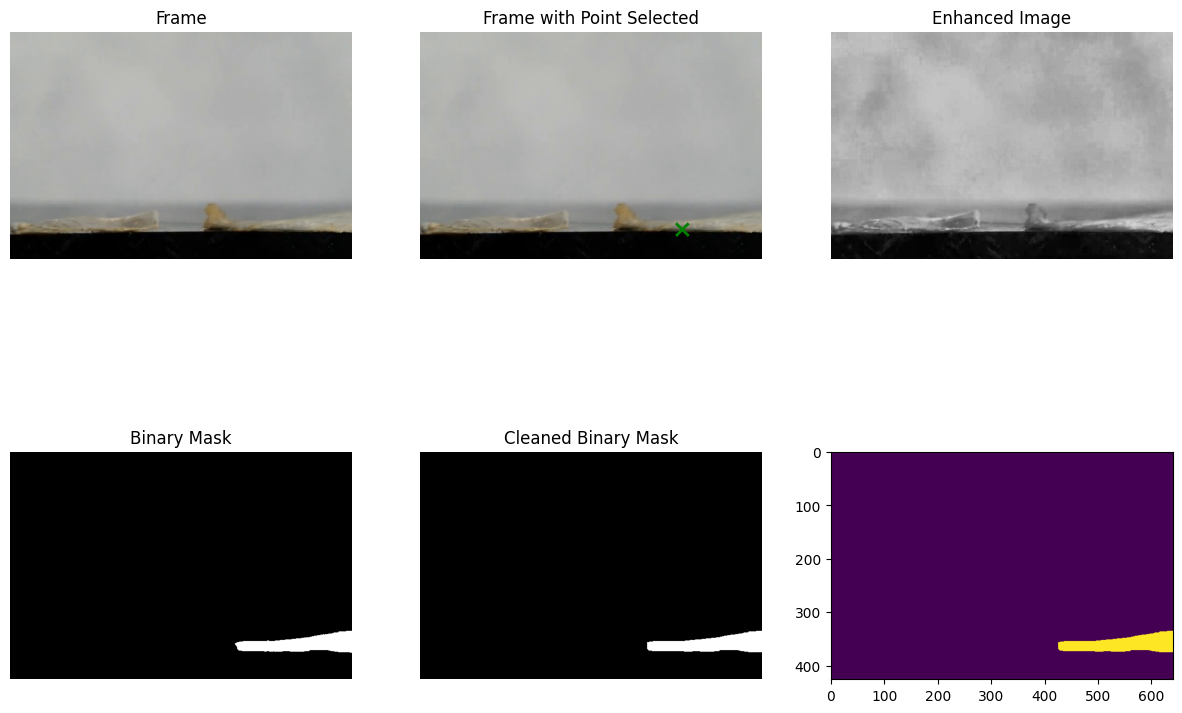

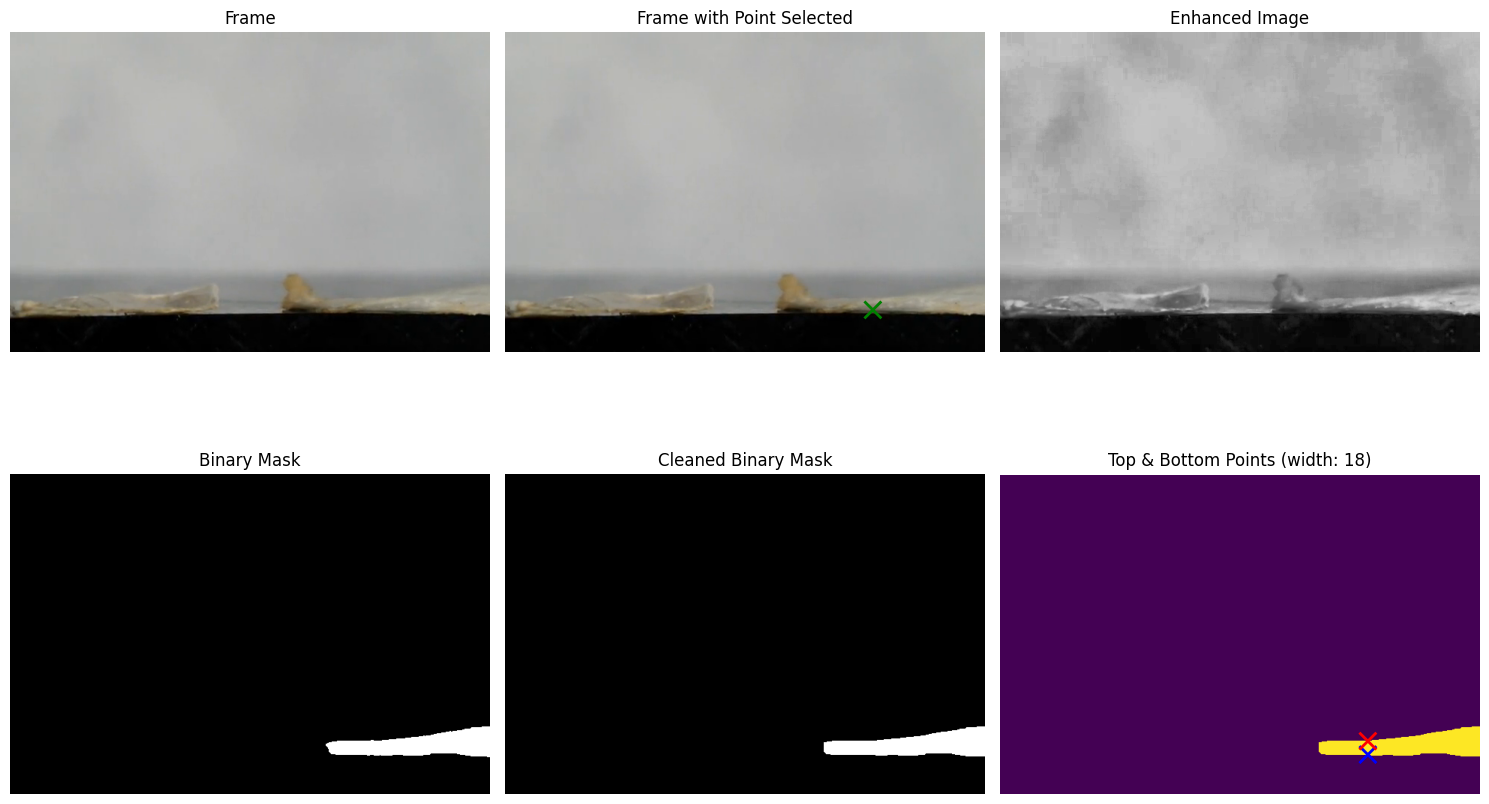


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_015_enhanced.png: 1024x1024 1 0, 327.8ms
Speed: 3.1ms preprocess, 327.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 14: Width = 16 bottom_most_y = 357 top_most_y = 373


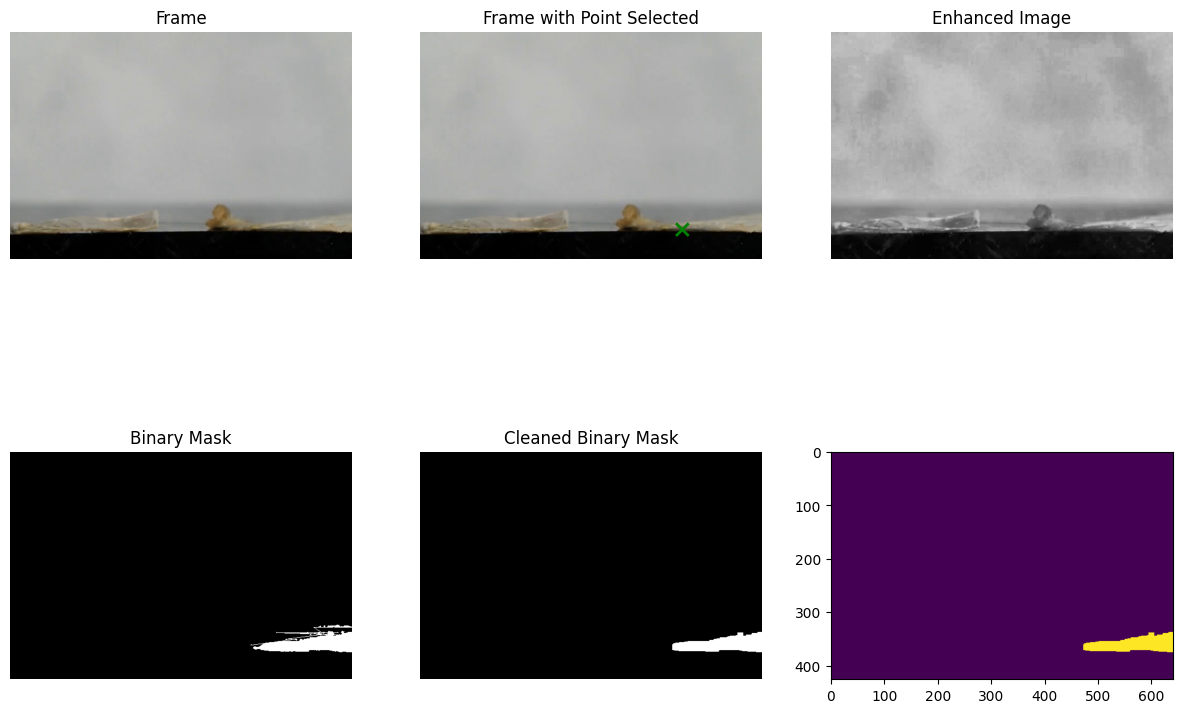

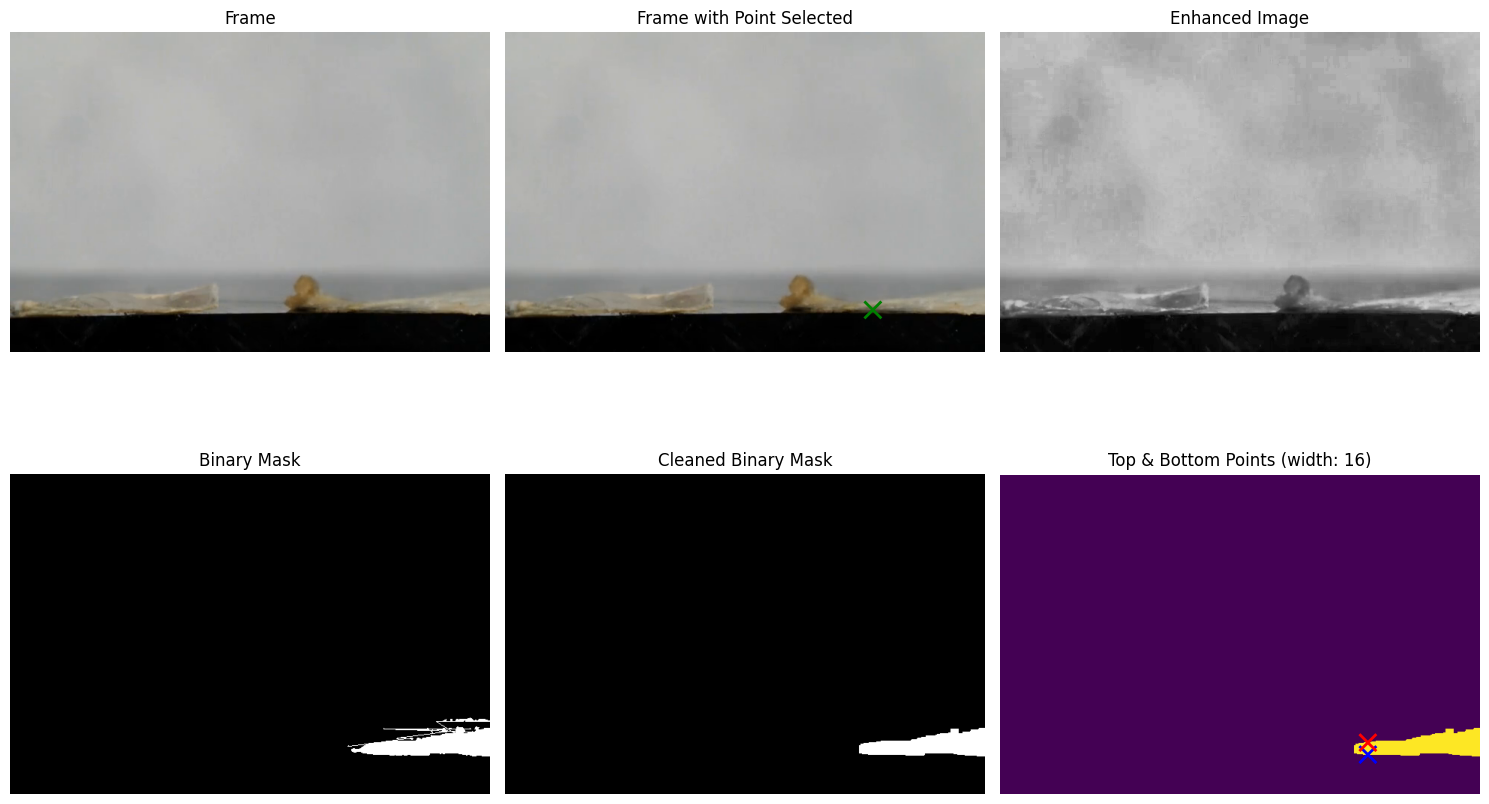


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_016_enhanced.png: 1024x1024 1 0, 326.8ms
Speed: 3.1ms preprocess, 326.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 15: Width = 11 bottom_most_y = 361 top_most_y = 372


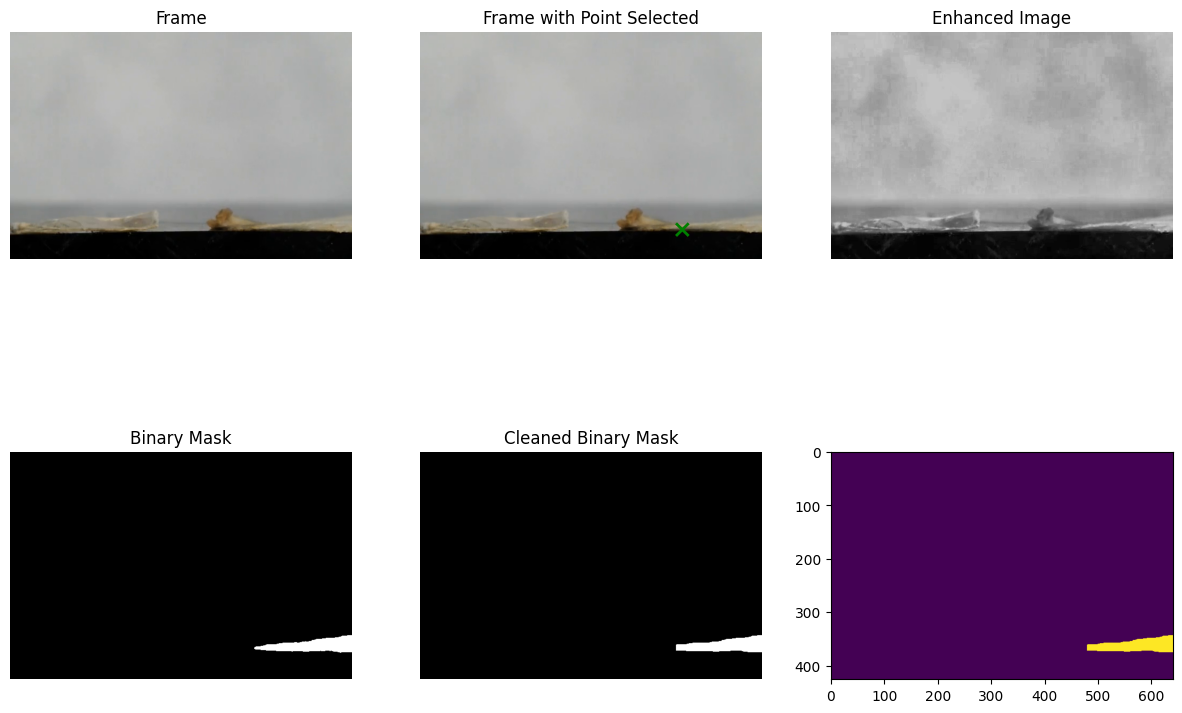

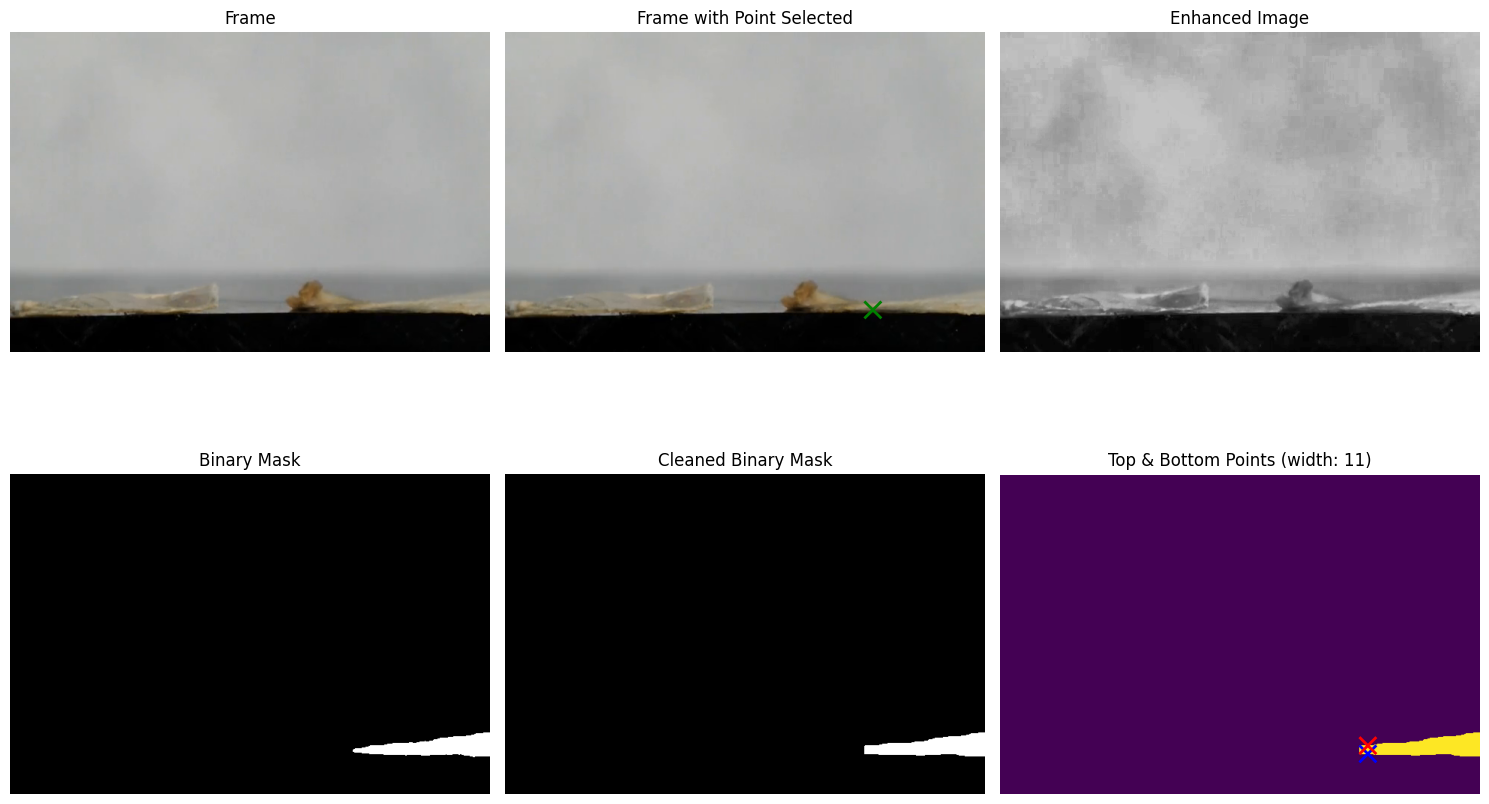


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_017_enhanced.png: 1024x1024 1 0, 325.6ms
Speed: 3.1ms preprocess, 325.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 16: Width = 10 bottom_most_y = 363 top_most_y = 373


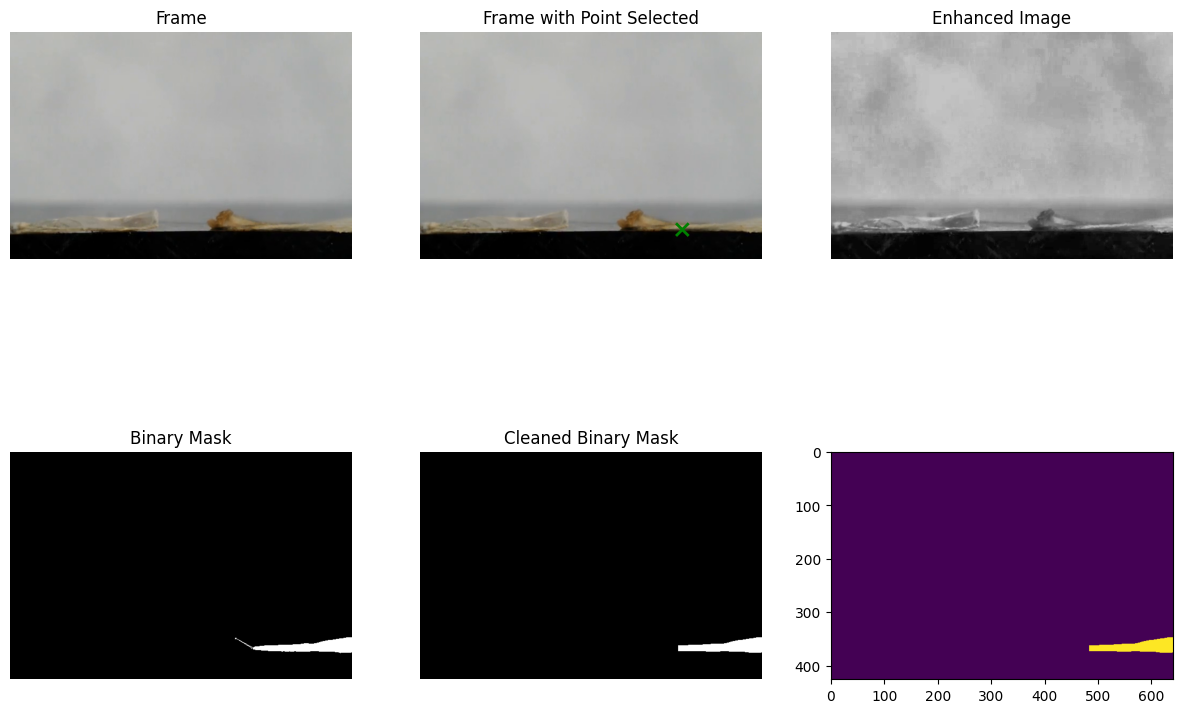

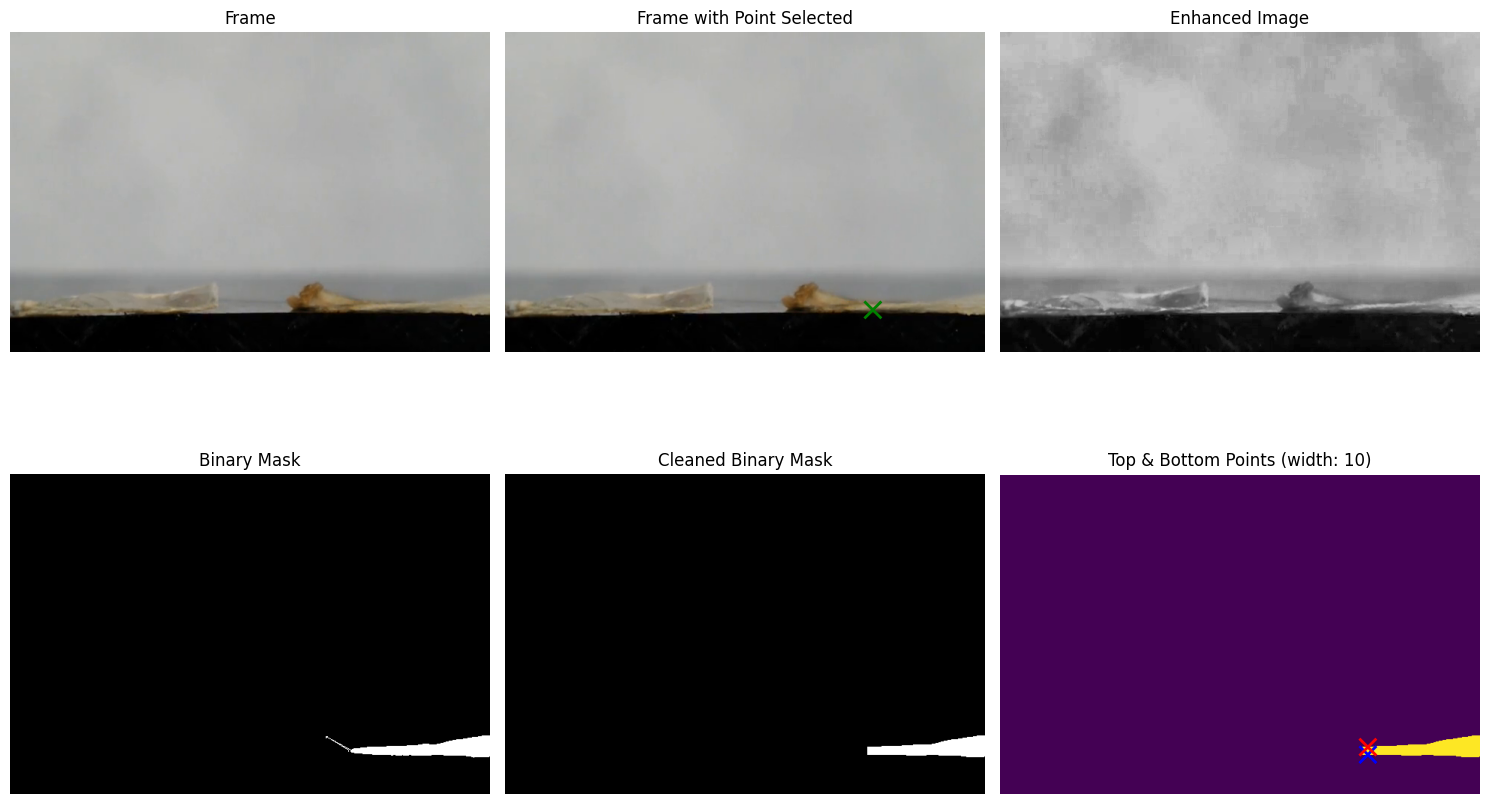


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/strain_rate_experiments/tracking_frames/frame_018_enhanced.png: 1024x1024 1 0, 326.5ms
Speed: 3.1ms preprocess, 326.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)


AssertionError: 

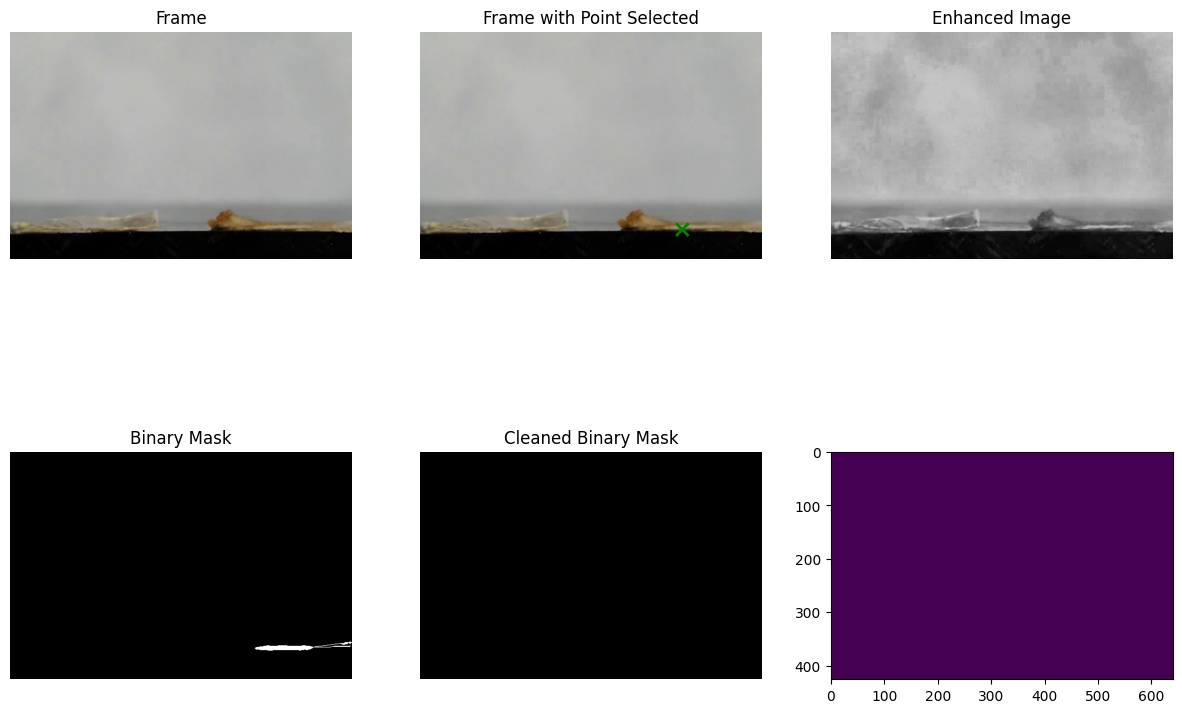

In [142]:
# Set paths
output_name = 'BslA_strain_rate_120C.csv'
video_name = f"drying_take_2_100x" # without the .mov
video_path = f"{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 0
end_frame = None
frame_interval=0.6
point = (490, 370)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_width(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=output_name,
    anchor_point=point,
    reverse_order=False,
    enhance_original_image=True,
    debug=True
)


for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)